In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from numpy import recarray

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms
import torch.utils.data as data
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

import os
import copy
import platform
import secrets

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
elif torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

on cuda


In [2]:
class mHealth(data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing data
        """
        self.dataset = dataframe

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index
        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 in (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1) #remove when using 3 dim, currently needed for 1 dim data
        
        return sequence

#pad sequences that aren't 128 length with 0's
def collate_fn(data):
    inputs = [torch.tensor(d) for d in data]

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        
        self.fc = nn.Linear(num_layers, 1)

    def forward(self, x):
        
        outputs, (hidden, cell) = self.lstm(x.to(device))
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        print("decoder layers: ", self.num_layers)
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size
        )

    def forward(self, x, hidden):
        
        hidden = (hidden[0], hidden[1])
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, seq_len, num_layers, device
    ):
        """
        input_size: int, number of input features, default=3
        hidden_size: int, size of hidden layer, default=256
        latent_size: int, latent z-layer size, default=128
        seq_size: int, sequence length of input
        num_layers: int, number of layers in LSTM, default=2
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # init
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.seq_len = seq_len
        self.num_layers = num_layers

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers
        )

        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )


        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_fix = nn.Linear(self.seq_len * self.num_layers, self.seq_len)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        x_hat = self.fc_fix(x_hat)

        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0].to(device).unsqueeze(dim=2)
        input = args[1].to(device)
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

0        -9.8184
1        -9.8489
2        -9.6602
3        -9.6507
4        -9.7030
           ...  
161275   -9.4032
161276   -9.5201
161277   -9.3682
161278   -8.6702
161279   -8.7211
Name: chest acceleration X-axis, Length: 161280, dtype: float64

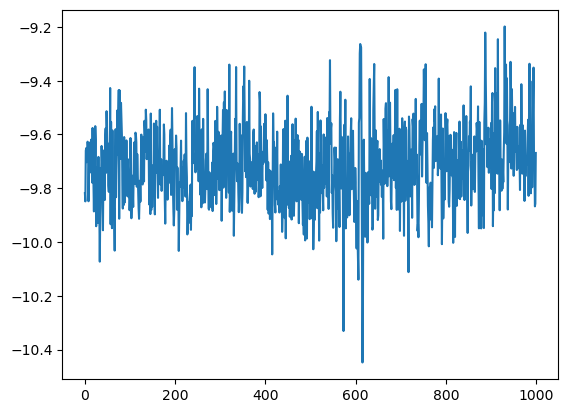

In [4]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = os.getcwd() + '/processed_data/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info
plt.plot(dataset[:1000])

dataset

In [5]:
LOAD_MODEL = True
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
)

batch_size = 128
input_size = 1
hidden_size = 256
latent_size = 128
sequence_len = 128
num_layers = 2
clip_value = 5

# define LSTM-based VAE model
if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)
    if(platform.system() == 'Darwin'):
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
    elif(platform.system() == 'Windows'):
        model.load_state_dict(torch.load('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\VAE+RNN\\lstm_vae\\state_dicts\\128_latent_2_layers_state_dict-aug-2'))
    else:
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layer_state_dict'))
        print("linux")
    print("model loaded from state dict | system: ", platform.system())
else:
    model = LSTMVAE(input_size, hidden_size, latent_size, sequence_len, num_layers, device=device)

model.to(device)
print("training on: ", device)
print('----------------------------------------------------------------\n', 
      model)

decoder layers:  2
model loaded from state dict | system:  Windows
training on:  cuda
----------------------------------------------------------------
 LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=2, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=256, out_features=128, bias=True)
  (fc22): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc_fix): Linear(in_features=256, out_features=128, bias=True)
)


In [6]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):
    datas = data
    print("datas shape: ", datas.shape)
    break

train_loss = []
test_loss = []
learning_rate = []

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x000002B208006550>
Length of train_dataloader: 1008 batches of 128
datas shape:  torch.Size([128, 128, 1])


C:\Users\Admin\AppData\Local\Temp\ipykernel_11488\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [7]:
def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

    ## interation setup
    epochs = tqdm(range(iterations // len(train_loader)))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )
        
        temp = -1
        
        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data = batch_data

            mloss, recon_x, recon_loss = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            temp = float(mloss.mean())
            
        if(temp != -1):
            train_loss.append(temp)
            
        before_lr = optimizer.param_groups[0]["lr"]
        learning_rate.append(float(before_lr))
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"test_loss": float(mloss.mean())})
                temp = float(mloss.mean())
            
        if(temp != -1):
            test_loss.append(temp)
        eval_loss = eval_loss / len(test_loader)
        print("Evaluation Score : [{}]".format(eval_loss))
        torch.cuda.empty_cache()

    return model


In [44]:
# iterations = 500000 ## iterations = total iterations, epochs = iterations / len(dataloader)
# train(iterations, model, train_loader, test_loader)

  0%|          | 0/496 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_25788\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
training: 1008it [01:00, 16.54it/s, train_loss=4.44]


Epoch 0: SGD lr 0.0010 -> 0.0010


  0%|          | 1/496 [01:07<9:13:58, 67.15s/it]

Evaluation Score : [1.2810322672483467]


training: 1008it [01:00, 16.57it/s, train_loss=3.9]


Epoch 1: SGD lr 0.0010 -> 0.0010


  0%|          | 2/496 [02:14<9:12:32, 67.11s/it]

Evaluation Score : [1.2521458142658783]


training: 1008it [01:00, 16.55it/s, train_loss=3.57]


Epoch 2: SGD lr 0.0010 -> 0.0010


  1%|          | 3/496 [03:21<9:11:42, 67.15s/it]

Evaluation Score : [1.2423112064984345]


training: 1008it [01:00, 16.55it/s, train_loss=3.42]


Epoch 3: SGD lr 0.0010 -> 0.0010


  1%|          | 4/496 [04:28<9:10:39, 67.15s/it]

Evaluation Score : [1.2382688712594765]


training: 1008it [01:00, 16.56it/s, train_loss=3.31]


Epoch 4: SGD lr 0.0010 -> 0.0010


  1%|          | 5/496 [05:35<9:09:24, 67.14s/it]

Evaluation Score : [1.2358007936309727]


training: 1008it [01:00, 16.53it/s, train_loss=3.28]


Epoch 5: SGD lr 0.0010 -> 0.0010


  1%|          | 6/496 [06:42<9:08:33, 67.17s/it]

Evaluation Score : [1.2317472533248957]


training: 1008it [01:00, 16.57it/s, train_loss=3.25]


Epoch 6: SGD lr 0.0010 -> 0.0010


  1%|▏         | 7/496 [07:49<9:07:09, 67.14s/it]

Evaluation Score : [1.2313912516932874]


training: 1008it [01:00, 16.58it/s, train_loss=3.24]


Epoch 7: SGD lr 0.0010 -> 0.0010


  2%|▏         | 8/496 [08:57<9:05:43, 67.10s/it]

Evaluation Score : [1.2285647408534137]


training: 1008it [01:00, 16.58it/s, train_loss=3.22]


Epoch 8: SGD lr 0.0010 -> 0.0010


  2%|▏         | 9/496 [10:04<9:04:31, 67.09s/it]

Evaluation Score : [1.2262309238107667]


training: 1008it [01:00, 16.54it/s, train_loss=3.18]


Epoch 9: SGD lr 0.0010 -> 0.0010


  2%|▏         | 10/496 [11:11<9:03:40, 67.12s/it]

Evaluation Score : [1.2246514888007254]


training: 1008it [01:01, 16.52it/s, train_loss=3.19]


Epoch 10: SGD lr 0.0010 -> 0.0010


  2%|▏         | 11/496 [12:18<9:02:48, 67.15s/it]

Evaluation Score : [1.2238498195739729]


training: 1008it [01:00, 16.57it/s, train_loss=3.16]


Epoch 11: SGD lr 0.0010 -> 0.0010


  2%|▏         | 12/496 [13:25<9:01:24, 67.12s/it]

Evaluation Score : [1.2220253756949826]


training: 1008it [01:00, 16.53it/s, train_loss=3.15]


Epoch 12: SGD lr 0.0010 -> 0.0010


  3%|▎         | 13/496 [14:32<9:00:36, 67.16s/it]

Evaluation Score : [1.2221577509882904]


training: 1008it [01:00, 16.54it/s, train_loss=3.13]


Epoch 13: SGD lr 0.0010 -> 0.0010


  3%|▎         | 14/496 [15:39<8:59:31, 67.16s/it]

Evaluation Score : [1.2196523319811574]


training: 1008it [01:00, 16.53it/s, train_loss=3.12]


Epoch 14: SGD lr 0.0010 -> 0.0010


  3%|▎         | 15/496 [16:47<8:58:33, 67.18s/it]

Evaluation Score : [1.2173984095247254]


training: 1008it [01:01, 16.52it/s, train_loss=3.11]


Epoch 15: SGD lr 0.0010 -> 0.0010


  3%|▎         | 16/496 [17:54<8:57:37, 67.20s/it]

Evaluation Score : [1.2165127827652864]


training: 1008it [01:00, 16.55it/s, train_loss=3.1]


Epoch 16: SGD lr 0.0010 -> 0.0010


  3%|▎         | 17/496 [19:01<8:56:26, 67.20s/it]

Evaluation Score : [1.2165220726931851]


training: 1008it [01:00, 16.55it/s, train_loss=3.08]


Epoch 17: SGD lr 0.0010 -> 0.0010


  4%|▎         | 18/496 [20:08<8:55:20, 67.20s/it]

Evaluation Score : [1.2147743207446875]


training: 1008it [01:00, 16.57it/s, train_loss=3.07]


Epoch 18: SGD lr 0.0010 -> 0.0010


  4%|▍         | 19/496 [21:15<8:53:52, 67.15s/it]

Evaluation Score : [1.212181586668723]


training: 1008it [01:00, 16.57it/s, train_loss=3.06]


Epoch 19: SGD lr 0.0010 -> 0.0010


  4%|▍         | 20/496 [22:23<8:52:48, 67.16s/it]

Evaluation Score : [1.2116464508460865]


training: 1008it [01:00, 16.56it/s, train_loss=3.06]


Epoch 20: SGD lr 0.0010 -> 0.0010


  4%|▍         | 21/496 [23:30<8:51:30, 67.14s/it]

Evaluation Score : [1.2112377070127025]


training: 1008it [01:00, 16.58it/s, train_loss=3.05]


Epoch 21: SGD lr 0.0010 -> 0.0010


  4%|▍         | 22/496 [24:37<8:50:09, 67.11s/it]

Evaluation Score : [1.2124094866984894]


training: 1008it [01:00, 16.58it/s, train_loss=3.04]


Epoch 22: SGD lr 0.0010 -> 0.0010


  5%|▍         | 23/496 [25:44<8:48:45, 67.07s/it]

Evaluation Score : [1.210169165705641]


training: 1008it [01:00, 16.57it/s, train_loss=3.04]


Epoch 23: SGD lr 0.0010 -> 0.0010


  5%|▍         | 24/496 [26:51<8:47:33, 67.06s/it]

Evaluation Score : [1.209571964950079]


training: 1008it [01:00, 16.55it/s, train_loss=3.03]


Epoch 24: SGD lr 0.0010 -> 0.0010


  5%|▌         | 25/496 [27:58<8:46:34, 67.08s/it]

Evaluation Score : [1.2071386872243786]


training: 1008it [01:00, 16.57it/s, train_loss=3.04]


Epoch 25: SGD lr 0.0010 -> 0.0010


  5%|▌         | 26/496 [29:05<8:45:19, 67.06s/it]

Evaluation Score : [1.2061413786861868]


training: 1008it [01:00, 16.59it/s, train_loss=3.02]


Epoch 26: SGD lr 0.0010 -> 0.0010


  5%|▌         | 27/496 [30:12<8:44:00, 67.04s/it]

Evaluation Score : [1.2051758311452374]


training: 1008it [01:00, 16.58it/s, train_loss=3]


Epoch 27: SGD lr 0.0010 -> 0.0010


  6%|▌         | 28/496 [31:19<8:42:48, 67.03s/it]

Evaluation Score : [1.2048950461700323]


training: 1008it [01:00, 16.58it/s, train_loss=3]


Epoch 28: SGD lr 0.0010 -> 0.0010


  6%|▌         | 29/496 [32:26<8:41:45, 67.04s/it]

Evaluation Score : [1.205040379649117]


training: 1008it [01:00, 16.54it/s, train_loss=2.99]


Epoch 29: SGD lr 0.0010 -> 0.0010


  6%|▌         | 30/496 [33:33<8:41:01, 67.08s/it]

Evaluation Score : [1.2035731681519084]


training: 1008it [01:00, 16.56it/s, train_loss=2.99]


Epoch 30: SGD lr 0.0010 -> 0.0010


  6%|▋         | 31/496 [34:40<8:39:54, 67.09s/it]

Evaluation Score : [1.2010480546732507]


training: 1008it [01:00, 16.56it/s, train_loss=2.99]


Epoch 31: SGD lr 0.0010 -> 0.0010


  6%|▋         | 32/496 [35:47<8:38:49, 67.09s/it]

Evaluation Score : [1.2019685893393461]


training: 1008it [01:00, 16.59it/s, train_loss=2.95]


Epoch 32: SGD lr 0.0010 -> 0.0010


  7%|▋         | 33/496 [36:54<8:37:25, 67.05s/it]

Evaluation Score : [1.2006822018958037]


training: 1008it [01:00, 16.63it/s, train_loss=2.97]


Epoch 33: SGD lr 0.0010 -> 0.0010


  7%|▋         | 34/496 [38:01<8:35:50, 66.99s/it]

Evaluation Score : [1.2007686669479996]


training: 1008it [01:00, 16.60it/s, train_loss=2.97]


Epoch 34: SGD lr 0.0010 -> 0.0010


  7%|▋         | 35/496 [39:08<8:34:43, 66.99s/it]

Evaluation Score : [1.1991760096409254]


training: 1008it [01:00, 16.63it/s, train_loss=2.96]


Epoch 35: SGD lr 0.0010 -> 0.0010


  7%|▋         | 36/496 [40:15<8:33:22, 66.96s/it]

Evaluation Score : [1.1976827390285]


training: 1008it [01:00, 16.63it/s, train_loss=2.95]


Epoch 36: SGD lr 0.0010 -> 0.0010


  7%|▋         | 37/496 [41:22<8:32:01, 66.93s/it]

Evaluation Score : [1.1976831194072488]


training: 1008it [01:00, 16.61it/s, train_loss=2.95]


Epoch 37: SGD lr 0.0010 -> 0.0010


  8%|▊         | 38/496 [42:29<8:30:48, 66.92s/it]

Evaluation Score : [1.1970974038990716]


training: 1008it [01:00, 16.61it/s, train_loss=2.94]


Epoch 38: SGD lr 0.0010 -> 0.0010


  8%|▊         | 39/496 [43:36<8:29:56, 66.95s/it]

Evaluation Score : [1.1965278307242053]


training: 1008it [01:00, 16.61it/s, train_loss=2.95]


Epoch 39: SGD lr 0.0010 -> 0.0010


  8%|▊         | 40/496 [44:43<8:28:46, 66.94s/it]

Evaluation Score : [1.1939119690999624]


training: 1008it [01:00, 16.62it/s, train_loss=2.99]


Epoch 40: SGD lr 0.0010 -> 0.0010


  8%|▊         | 41/496 [45:50<8:27:33, 66.93s/it]

Evaluation Score : [1.1957651803654337]


training: 1008it [01:00, 16.60it/s, train_loss=2.98]


Epoch 41: SGD lr 0.0010 -> 0.0010


  8%|▊         | 42/496 [46:57<8:26:32, 66.94s/it]

Evaluation Score : [1.195024629108726]


training: 1008it [01:00, 16.60it/s, train_loss=2.94]


Epoch 42: SGD lr 0.0010 -> 0.0010


  9%|▊         | 43/496 [48:04<8:25:29, 66.95s/it]

Evaluation Score : [1.1938615439991866]


training: 1008it [01:00, 16.59it/s, train_loss=2.98]


Epoch 43: SGD lr 0.0010 -> 0.0010


  9%|▉         | 44/496 [49:11<8:24:31, 66.97s/it]

Evaluation Score : [1.1908718928665158]


training: 1008it [01:00, 16.61it/s, train_loss=2.95]


Epoch 44: SGD lr 0.0010 -> 0.0010


  9%|▉         | 45/496 [50:17<8:23:16, 66.96s/it]

Evaluation Score : [1.1893965551067913]


training: 1008it [01:00, 16.61it/s, train_loss=2.97]


Epoch 45: SGD lr 0.0010 -> 0.0010


  9%|▉         | 46/496 [51:24<8:22:03, 66.94s/it]

Evaluation Score : [1.1908468686872058]


training: 1008it [01:00, 16.62it/s, train_loss=2.94]


Epoch 46: SGD lr 0.0010 -> 0.0010


  9%|▉         | 47/496 [52:31<8:20:57, 66.94s/it]

Evaluation Score : [1.1903550939870968]


training: 1008it [01:00, 16.60it/s, train_loss=2.94]


Epoch 47: SGD lr 0.0010 -> 0.0010


 10%|▉         | 48/496 [53:38<8:20:00, 66.97s/it]

Evaluation Score : [1.1891228609112283]


training: 1008it [01:00, 16.59it/s, train_loss=2.92]


Epoch 48: SGD lr 0.0010 -> 0.0010


 10%|▉         | 49/496 [54:45<8:19:00, 66.98s/it]

Evaluation Score : [1.187419994246392]


training: 1008it [01:00, 16.61it/s, train_loss=2.9]


Epoch 49: SGD lr 0.0010 -> 0.0010


 10%|█         | 50/496 [55:52<8:17:46, 66.97s/it]

Evaluation Score : [1.1886983813333607]


training: 1008it [01:00, 16.61it/s, train_loss=2.89]


Epoch 50: SGD lr 0.0010 -> 0.0010


 10%|█         | 51/496 [56:59<8:16:30, 66.94s/it]

Evaluation Score : [1.1880873772241767]


training: 1008it [01:00, 16.61it/s, train_loss=2.94]


Epoch 51: SGD lr 0.0010 -> 0.0010


 10%|█         | 52/496 [58:06<8:15:17, 66.93s/it]

Evaluation Score : [1.1864350203956877]


training: 1008it [01:00, 16.59it/s, train_loss=2.91]


Epoch 52: SGD lr 0.0010 -> 0.0010


 11%|█         | 53/496 [59:13<8:14:26, 66.97s/it]

Evaluation Score : [1.1889783023368745]


training: 1008it [01:00, 16.59it/s, train_loss=2.91]


Epoch 53: SGD lr 0.0010 -> 0.0010


 11%|█         | 54/496 [1:00:20<8:13:31, 66.99s/it]

Evaluation Score : [1.1850411551487114]


training: 1008it [01:00, 16.60it/s, train_loss=2.93]


Epoch 54: SGD lr 0.0010 -> 0.0010


 11%|█         | 55/496 [1:01:27<8:12:22, 66.99s/it]

Evaluation Score : [1.184895680463385]


training: 1008it [01:00, 16.60it/s, train_loss=2.9]


Epoch 55: SGD lr 0.0010 -> 0.0010


 11%|█▏        | 56/496 [1:02:34<8:11:10, 66.98s/it]

Evaluation Score : [1.184737150291247]


training: 1008it [01:00, 16.57it/s, train_loss=2.89]


Epoch 56: SGD lr 0.0010 -> 0.0010


 11%|█▏        | 57/496 [1:03:41<8:10:11, 67.00s/it]

Evaluation Score : [1.1834155013341279]


training: 1008it [01:00, 16.57it/s, train_loss=2.9]


Epoch 57: SGD lr 0.0010 -> 0.0010


 12%|█▏        | 58/496 [1:04:48<8:09:30, 67.06s/it]

Evaluation Score : [1.1830927568029552]


training: 1008it [01:00, 16.56it/s, train_loss=2.88]


Epoch 58: SGD lr 0.0010 -> 0.0010


 12%|█▏        | 59/496 [1:05:55<8:08:26, 67.06s/it]

Evaluation Score : [1.1831052586850193]


training: 1008it [01:00, 16.56it/s, train_loss=2.92]


Epoch 59: SGD lr 0.0010 -> 0.0010


 12%|█▏        | 60/496 [1:07:03<8:07:26, 67.08s/it]

Evaluation Score : [1.1808404235080594]


training: 1008it [01:00, 16.57it/s, train_loss=2.88]


Epoch 60: SGD lr 0.0010 -> 0.0010


 12%|█▏        | 61/496 [1:08:10<8:06:13, 67.07s/it]

Evaluation Score : [1.1796582171634313]


training: 1008it [01:00, 16.59it/s, train_loss=2.86]


Epoch 61: SGD lr 0.0010 -> 0.0010


 12%|█▎        | 62/496 [1:09:17<8:04:53, 67.04s/it]

Evaluation Score : [1.1804279742821577]


training: 1008it [01:00, 16.56it/s, train_loss=2.87]


Epoch 62: SGD lr 0.0010 -> 0.0010


 13%|█▎        | 63/496 [1:10:24<8:03:58, 67.06s/it]

Evaluation Score : [1.1795003739969125]


training: 1008it [01:00, 16.57it/s, train_loss=2.86]


Epoch 63: SGD lr 0.0010 -> 0.0010


 13%|█▎        | 64/496 [1:11:31<8:02:46, 67.05s/it]

Evaluation Score : [1.1793869890065656]


training: 1008it [01:00, 16.59it/s, train_loss=2.88]


Epoch 64: SGD lr 0.0010 -> 0.0010


 13%|█▎        | 65/496 [1:12:38<8:01:31, 67.03s/it]

Evaluation Score : [1.1777909998412406]


training: 1008it [01:00, 16.57it/s, train_loss=2.9]


Epoch 65: SGD lr 0.0010 -> 0.0010


 13%|█▎        | 66/496 [1:13:45<8:00:27, 67.04s/it]

Evaluation Score : [1.1780531164554378]


training: 1008it [01:00, 16.55it/s, train_loss=2.86]


Epoch 66: SGD lr 0.0010 -> 0.0010


 14%|█▎        | 67/496 [1:14:52<7:59:31, 67.07s/it]

Evaluation Score : [1.1759147480691945]


training: 1008it [01:00, 16.54it/s, train_loss=2.87]


Epoch 67: SGD lr 0.0010 -> 0.0010


 14%|█▎        | 68/496 [1:15:59<7:58:34, 67.09s/it]

Evaluation Score : [1.1777928590271918]


training: 1008it [01:00, 16.58it/s, train_loss=2.88]


Epoch 68: SGD lr 0.0010 -> 0.0010


 14%|█▍        | 69/496 [1:17:06<7:57:20, 67.07s/it]

Evaluation Score : [1.1759724516480687]


training: 1008it [01:00, 16.58it/s, train_loss=2.89]


Epoch 69: SGD lr 0.0010 -> 0.0010


 14%|█▍        | 70/496 [1:18:13<7:56:03, 67.05s/it]

Evaluation Score : [1.175695895808675]


training: 1008it [01:00, 16.58it/s, train_loss=2.89]


Epoch 70: SGD lr 0.0010 -> 0.0010


 14%|█▍        | 71/496 [1:19:20<7:54:50, 67.04s/it]

Evaluation Score : [1.1761896802437684]


training: 1008it [01:00, 16.58it/s, train_loss=2.88]


Epoch 71: SGD lr 0.0010 -> 0.0010


 15%|█▍        | 72/496 [1:20:27<7:53:44, 67.04s/it]

Evaluation Score : [1.173216820738855]


training: 1008it [01:01, 16.51it/s, train_loss=2.84]


Epoch 72: SGD lr 0.0010 -> 0.0010


 15%|█▍        | 73/496 [1:21:34<7:53:07, 67.11s/it]

Evaluation Score : [1.1736315036902116]


training: 1008it [01:00, 16.59it/s, train_loss=2.85]


Epoch 73: SGD lr 0.0010 -> 0.0010


 15%|█▍        | 74/496 [1:22:41<7:51:43, 67.07s/it]

Evaluation Score : [1.1740755969510666]


training: 1008it [01:00, 16.58it/s, train_loss=2.84]


Epoch 74: SGD lr 0.0010 -> 0.0010


 15%|█▌        | 75/496 [1:23:48<7:50:39, 67.08s/it]

Evaluation Score : [1.1734080216921274]


training: 1008it [01:00, 16.53it/s, train_loss=2.87]


Epoch 75: SGD lr 0.0010 -> 0.0010


 15%|█▌        | 76/496 [1:24:56<7:49:50, 67.12s/it]

Evaluation Score : [1.172556855479285]


training: 1008it [01:00, 16.56it/s, train_loss=2.83]


Epoch 76: SGD lr 0.0010 -> 0.0010


 16%|█▌        | 77/496 [1:26:03<7:48:36, 67.10s/it]

Evaluation Score : [1.1713888703416737]


training: 1008it [01:00, 16.57it/s, train_loss=2.84]


Epoch 77: SGD lr 0.0010 -> 0.0010


 16%|█▌        | 78/496 [1:27:10<7:47:19, 67.08s/it]

Evaluation Score : [1.1717220430543263]


training: 1008it [01:00, 16.57it/s, train_loss=2.85]


Epoch 78: SGD lr 0.0010 -> 0.0010


 16%|█▌        | 79/496 [1:28:17<7:46:10, 67.08s/it]

Evaluation Score : [1.1703226657673007]


training: 1008it [01:00, 16.59it/s, train_loss=2.85]


Epoch 79: SGD lr 0.0010 -> 0.0010


 16%|█▌        | 80/496 [1:29:24<7:44:49, 67.04s/it]

Evaluation Score : [1.1689068559586766]


training: 1008it [01:00, 16.59it/s, train_loss=2.83]


Epoch 80: SGD lr 0.0010 -> 0.0010


 16%|█▋        | 81/496 [1:30:31<7:43:31, 67.01s/it]

Evaluation Score : [1.1679376954922365]


training: 1008it [01:00, 16.57it/s, train_loss=2.83]


Epoch 81: SGD lr 0.0010 -> 0.0010


 17%|█▋        | 82/496 [1:31:38<7:42:30, 67.03s/it]

Evaluation Score : [1.1675036556959626]


training: 1008it [01:00, 16.57it/s, train_loss=2.85]


Epoch 82: SGD lr 0.0010 -> 0.0010


 17%|█▋        | 83/496 [1:32:45<7:41:30, 67.05s/it]

Evaluation Score : [1.1689586898252842]


training: 1008it [01:00, 16.58it/s, train_loss=2.86]


Epoch 83: SGD lr 0.0010 -> 0.0010


 17%|█▋        | 84/496 [1:33:52<7:40:17, 67.03s/it]

Evaluation Score : [1.1676975042514859]


training: 1008it [01:00, 16.57it/s, train_loss=2.84]


Epoch 84: SGD lr 0.0010 -> 0.0010


 17%|█▋        | 85/496 [1:34:59<7:39:11, 67.03s/it]

Evaluation Score : [1.1665500894573235]


training: 1008it [01:00, 16.64it/s, train_loss=2.85]


Epoch 85: SGD lr 0.0010 -> 0.0010


 17%|█▋        | 86/496 [1:36:06<7:37:37, 66.97s/it]

Evaluation Score : [1.1675473853857035]


training: 1008it [01:00, 16.60it/s, train_loss=2.82]


Epoch 86: SGD lr 0.0010 -> 0.0010


 18%|█▊        | 87/496 [1:37:13<7:36:30, 66.97s/it]

Evaluation Score : [1.1672432166745974]


training: 1008it [01:00, 16.62it/s, train_loss=2.83]


Epoch 87: SGD lr 0.0010 -> 0.0010


 18%|█▊        | 88/496 [1:38:20<7:35:14, 66.95s/it]

Evaluation Score : [1.1659383427144752]


training: 1008it [01:00, 16.61it/s, train_loss=2.84]


Epoch 88: SGD lr 0.0010 -> 0.0010


 18%|█▊        | 89/496 [1:39:27<7:34:04, 66.94s/it]

Evaluation Score : [1.1657008335349106]


training: 1008it [01:00, 16.58it/s, train_loss=2.85]


Epoch 89: SGD lr 0.0010 -> 0.0010


 18%|█▊        | 90/496 [1:40:33<7:33:01, 66.95s/it]

Evaluation Score : [1.1638936850404928]


training: 1008it [01:00, 16.61it/s, train_loss=2.84]


Epoch 90: SGD lr 0.0010 -> 0.0010


 18%|█▊        | 91/496 [1:41:40<7:31:59, 66.96s/it]

Evaluation Score : [1.1646485569192067]


training: 1008it [01:00, 16.63it/s, train_loss=2.84]


Epoch 91: SGD lr 0.0010 -> 0.0010


 19%|█▊        | 92/496 [1:42:47<7:30:37, 66.93s/it]

Evaluation Score : [1.1628795532243592]


training: 1008it [01:00, 16.60it/s, train_loss=2.8]


Epoch 92: SGD lr 0.0010 -> 0.0010


 19%|█▉        | 93/496 [1:43:54<7:29:30, 66.93s/it]

Evaluation Score : [1.164803751581718]


training: 1008it [01:00, 16.62it/s, train_loss=2.83]


Epoch 93: SGD lr 0.0010 -> 0.0010


 19%|█▉        | 94/496 [1:45:01<7:28:10, 66.89s/it]

Evaluation Score : [1.1625395315654932]


training: 1008it [01:00, 16.61it/s, train_loss=2.82]


Epoch 94: SGD lr 0.0010 -> 0.0010


 19%|█▉        | 95/496 [1:46:08<7:27:03, 66.89s/it]

Evaluation Score : [1.1630468294467955]


training: 1008it [01:00, 16.57it/s, train_loss=2.79]


Epoch 95: SGD lr 0.0010 -> 0.0010


 19%|█▉        | 96/496 [1:47:15<7:26:15, 66.94s/it]

Evaluation Score : [1.1609892764882672]


training: 1008it [01:00, 16.61it/s, train_loss=2.78]


Epoch 96: SGD lr 0.0010 -> 0.0010


 20%|█▉        | 97/496 [1:48:22<7:25:03, 66.93s/it]

Evaluation Score : [1.1621502302291373]


training: 1008it [01:00, 16.65it/s, train_loss=2.83]


Epoch 97: SGD lr 0.0010 -> 0.0010


 20%|█▉        | 98/496 [1:49:29<7:23:36, 66.87s/it]

Evaluation Score : [1.1610326056501694]


training: 1008it [01:00, 16.64it/s, train_loss=2.8]


Epoch 98: SGD lr 0.0010 -> 0.0010


 20%|█▉        | 99/496 [1:50:35<7:22:15, 66.84s/it]

Evaluation Score : [1.1598248359348093]


training: 1008it [01:00, 16.63it/s, train_loss=2.81]


Epoch 99: SGD lr 0.0010 -> 0.0010


 20%|██        | 100/496 [1:51:42<7:21:04, 66.83s/it]

Evaluation Score : [1.1600488386013441]


training: 1008it [01:00, 16.57it/s, train_loss=2.83]


Epoch 100: SGD lr 0.0010 -> 0.0010


 20%|██        | 101/496 [1:52:49<7:20:20, 66.89s/it]

Evaluation Score : [1.1587937127296177]


training: 1008it [01:00, 16.59it/s, train_loss=2.81]


Epoch 101: SGD lr 0.0010 -> 0.0010


 21%|██        | 102/496 [1:53:56<7:19:24, 66.91s/it]

Evaluation Score : [1.160852447137355]


training: 1008it [01:00, 16.63it/s, train_loss=2.81]


Epoch 102: SGD lr 0.0010 -> 0.0010


 21%|██        | 103/496 [1:55:03<7:18:06, 66.89s/it]

Evaluation Score : [1.1586406774493674]


training: 1008it [01:01, 16.46it/s, train_loss=2.8]


Epoch 103: SGD lr 0.0010 -> 0.0010


 21%|██        | 104/496 [1:56:11<7:18:23, 67.10s/it]

Evaluation Score : [1.1576511470660094]


training: 1008it [01:01, 16.47it/s, train_loss=2.79]


Epoch 104: SGD lr 0.0010 -> 0.0010


 21%|██        | 105/496 [1:57:18<7:18:09, 67.24s/it]

Evaluation Score : [1.1570550529434094]


training: 1008it [01:01, 16.43it/s, train_loss=2.82]


Epoch 105: SGD lr 0.0010 -> 0.0010


 21%|██▏       | 106/496 [1:58:26<7:18:03, 67.39s/it]

Evaluation Score : [1.157469611127107]


training: 1008it [01:01, 16.49it/s, train_loss=2.78]


Epoch 106: SGD lr 0.0010 -> 0.0010


 22%|██▏       | 107/496 [1:59:33<7:16:54, 67.39s/it]

Evaluation Score : [1.154616157051235]


training: 1008it [01:01, 16.47it/s, train_loss=2.78]


Epoch 107: SGD lr 0.0010 -> 0.0010


 22%|██▏       | 108/496 [2:00:41<7:16:00, 67.42s/it]

Evaluation Score : [1.15633788607305]


training: 1008it [01:00, 16.56it/s, train_loss=2.8]


Epoch 108: SGD lr 0.0010 -> 0.0010


 22%|██▏       | 109/496 [2:01:48<7:14:18, 67.33s/it]

Evaluation Score : [1.1552500898343703]


training: 1008it [01:00, 16.62it/s, train_loss=2.78]


Epoch 109: SGD lr 0.0010 -> 0.0010


 22%|██▏       | 110/496 [2:02:55<7:12:28, 67.22s/it]

Evaluation Score : [1.1544682568767004]


training: 1008it [01:00, 16.63it/s, train_loss=2.81]


Epoch 110: SGD lr 0.0010 -> 0.0010


 22%|██▏       | 111/496 [2:04:02<7:10:37, 67.11s/it]

Evaluation Score : [1.1537958186799808]


training: 1008it [01:00, 16.63it/s, train_loss=2.79]


Epoch 111: SGD lr 0.0010 -> 0.0010


 23%|██▎       | 112/496 [2:05:09<7:09:09, 67.06s/it]

Evaluation Score : [1.1566133152190892]


training: 1008it [01:00, 16.60it/s, train_loss=2.77]


Epoch 112: SGD lr 0.0010 -> 0.0010


 23%|██▎       | 113/496 [2:06:16<7:07:49, 67.02s/it]

Evaluation Score : [1.152364180053747]


training: 1008it [01:00, 16.60it/s, train_loss=2.76]


Epoch 113: SGD lr 0.0010 -> 0.0010


 23%|██▎       | 114/496 [2:07:23<7:06:31, 66.99s/it]

Evaluation Score : [1.1526466092272174]


training: 1008it [01:00, 16.58it/s, train_loss=2.74]


Epoch 114: SGD lr 0.0010 -> 0.0010


 23%|██▎       | 115/496 [2:08:30<7:05:28, 67.00s/it]

Evaluation Score : [1.151817797579699]


training: 1008it [01:00, 16.61it/s, train_loss=2.76]


Epoch 115: SGD lr 0.0010 -> 0.0010


 23%|██▎       | 116/496 [2:09:36<7:04:08, 66.97s/it]

Evaluation Score : [1.1521879821454013]


training: 1008it [01:00, 16.59it/s, train_loss=2.78]


Epoch 116: SGD lr 0.0010 -> 0.0010


 24%|██▎       | 117/496 [2:10:43<7:02:58, 66.96s/it]

Evaluation Score : [1.1535360365514717]


training: 1008it [01:00, 16.63it/s, train_loss=2.79]


Epoch 117: SGD lr 0.0010 -> 0.0010


 24%|██▍       | 118/496 [2:11:50<7:01:39, 66.93s/it]

Evaluation Score : [1.1523824719239086]


training: 1008it [01:00, 16.62it/s, train_loss=2.78]


Epoch 118: SGD lr 0.0010 -> 0.0010


 24%|██▍       | 119/496 [2:12:57<7:00:24, 66.91s/it]

Evaluation Score : [1.1504117705016619]


training: 1008it [01:00, 16.58it/s, train_loss=2.78]


Epoch 119: SGD lr 0.0010 -> 0.0010


 24%|██▍       | 120/496 [2:14:04<6:59:25, 66.93s/it]

Evaluation Score : [1.1509213752246328]


training: 1008it [01:00, 16.59it/s, train_loss=2.77]


Epoch 120: SGD lr 0.0010 -> 0.0010


 24%|██▍       | 121/496 [2:15:11<6:58:26, 66.95s/it]

Evaluation Score : [1.1503707909040035]


training: 1008it [01:00, 16.60it/s, train_loss=2.76]


Epoch 121: SGD lr 0.0010 -> 0.0010


 25%|██▍       | 122/496 [2:16:18<6:57:20, 66.95s/it]

Evaluation Score : [1.1493300090115222]


training: 1008it [01:00, 16.61it/s, train_loss=2.73]


Epoch 122: SGD lr 0.0010 -> 0.0010


 25%|██▍       | 123/496 [2:17:25<6:56:07, 66.94s/it]

Evaluation Score : [1.149641394349081]


training: 1008it [01:00, 16.60it/s, train_loss=2.77]


Epoch 123: SGD lr 0.0010 -> 0.0010


 25%|██▌       | 124/496 [2:18:32<6:54:56, 66.93s/it]

Evaluation Score : [1.1499551526522116]


training: 1008it [01:00, 16.57it/s, train_loss=2.81]


Epoch 124: SGD lr 0.0010 -> 0.0010


 25%|██▌       | 125/496 [2:19:39<6:54:00, 66.96s/it]

Evaluation Score : [1.1496738651471714]


training: 1008it [01:00, 16.60it/s, train_loss=2.76]


Epoch 125: SGD lr 0.0010 -> 0.0010


 25%|██▌       | 126/496 [2:20:46<6:52:47, 66.94s/it]

Evaluation Score : [1.14646437530598]


training: 1008it [01:00, 16.63it/s, train_loss=2.81]


Epoch 126: SGD lr 0.0010 -> 0.0010


 26%|██▌       | 127/496 [2:21:53<6:51:26, 66.90s/it]

Evaluation Score : [1.1490397076492036]


training: 1008it [01:00, 16.63it/s, train_loss=2.77]


Epoch 127: SGD lr 0.0010 -> 0.0010


 26%|██▌       | 128/496 [2:22:59<6:50:10, 66.88s/it]

Evaluation Score : [1.1463308522832536]


training: 1008it [01:00, 16.63it/s, train_loss=2.75]


Epoch 128: SGD lr 0.0010 -> 0.0010


 26%|██▌       | 129/496 [2:24:06<6:49:05, 66.88s/it]

Evaluation Score : [1.1482287242062508]


training: 1008it [01:00, 16.61it/s, train_loss=2.76]


Epoch 129: SGD lr 0.0010 -> 0.0010


 26%|██▌       | 130/496 [2:25:13<6:47:56, 66.88s/it]

Evaluation Score : [1.1450895968499402]


training: 1008it [01:00, 16.61it/s, train_loss=2.77]


Epoch 130: SGD lr 0.0010 -> 0.0010


 26%|██▋       | 131/496 [2:26:20<6:46:47, 66.87s/it]

Evaluation Score : [1.1468667429797943]


training: 1008it [01:00, 16.65it/s, train_loss=2.76]


Epoch 131: SGD lr 0.0010 -> 0.0010


 27%|██▋       | 132/496 [2:27:27<6:45:23, 66.82s/it]

Evaluation Score : [1.1434943389058823]


training: 1008it [01:00, 16.61it/s, train_loss=2.75]


Epoch 132: SGD lr 0.0010 -> 0.0010


 27%|██▋       | 133/496 [2:28:34<6:44:19, 66.83s/it]

Evaluation Score : [1.14591147209562]


training: 1008it [01:00, 16.59it/s, train_loss=2.77]


Epoch 133: SGD lr 0.0010 -> 0.0010


 27%|██▋       | 134/496 [2:29:41<6:43:22, 66.86s/it]

Evaluation Score : [1.1447502741412747]


training: 1008it [01:00, 16.63it/s, train_loss=2.76]


Epoch 134: SGD lr 0.0010 -> 0.0010


 27%|██▋       | 135/496 [2:30:47<6:42:06, 66.83s/it]

Evaluation Score : [1.143823833751773]


training: 1008it [01:00, 16.61it/s, train_loss=2.8]


Epoch 135: SGD lr 0.0010 -> 0.0010


 27%|██▋       | 136/496 [2:31:54<6:40:59, 66.83s/it]

Evaluation Score : [1.14260978432047]


training: 1008it [01:00, 16.65it/s, train_loss=2.76]


Epoch 136: SGD lr 0.0010 -> 0.0010


 28%|██▊       | 137/496 [2:33:01<6:39:41, 66.80s/it]

Evaluation Score : [1.1424808408030205]


training: 1008it [01:00, 16.63it/s, train_loss=2.74]


Epoch 137: SGD lr 0.0010 -> 0.0010


 28%|██▊       | 138/496 [2:34:08<6:38:35, 66.80s/it]

Evaluation Score : [1.1412696393413677]


training: 1008it [01:00, 16.61it/s, train_loss=2.77]


Epoch 138: SGD lr 0.0010 -> 0.0010


 28%|██▊       | 139/496 [2:35:15<6:37:36, 66.82s/it]

Evaluation Score : [1.142337254174645]


training: 1008it [01:00, 16.61it/s, train_loss=2.76]


Epoch 139: SGD lr 0.0010 -> 0.0010


 28%|██▊       | 140/496 [2:36:21<6:36:32, 66.83s/it]

Evaluation Score : [1.1421472636450614]


training: 1008it [01:00, 16.63it/s, train_loss=2.75]


Epoch 140: SGD lr 0.0010 -> 0.0010


 28%|██▊       | 141/496 [2:37:28<6:35:20, 66.82s/it]

Evaluation Score : [1.1403698676103164]


training: 1008it [01:00, 16.64it/s, train_loss=2.77]


Epoch 141: SGD lr 0.0010 -> 0.0010


 29%|██▊       | 142/496 [2:38:35<6:34:02, 66.79s/it]

Evaluation Score : [1.1382304237386773]


training: 1008it [01:00, 16.64it/s, train_loss=2.75]


Epoch 142: SGD lr 0.0010 -> 0.0010


 29%|██▉       | 143/496 [2:39:42<6:32:53, 66.78s/it]

Evaluation Score : [1.14038997449513]


training: 1008it [01:00, 16.61it/s, train_loss=2.79]


Epoch 143: SGD lr 0.0010 -> 0.0009


 29%|██▉       | 144/496 [2:40:49<6:31:57, 66.81s/it]

Evaluation Score : [1.1403845765199216]


training: 1008it [01:00, 16.62it/s, train_loss=2.73]


Epoch 144: SGD lr 0.0009 -> 0.0009


 29%|██▉       | 145/496 [2:41:55<6:30:54, 66.82s/it]

Evaluation Score : [1.138972273702541]


training: 1008it [01:00, 16.63it/s, train_loss=2.73]


Epoch 145: SGD lr 0.0009 -> 0.0009


 29%|██▉       | 146/496 [2:43:02<6:29:46, 66.82s/it]

Evaluation Score : [1.1380052683608872]


training: 1008it [01:00, 16.61it/s, train_loss=2.73]


Epoch 146: SGD lr 0.0009 -> 0.0009


 30%|██▉       | 147/496 [2:44:09<6:28:41, 66.82s/it]

Evaluation Score : [1.1409482765085404]


training: 1008it [01:00, 16.59it/s, train_loss=2.77]


Epoch 147: SGD lr 0.0009 -> 0.0009


 30%|██▉       | 148/496 [2:45:16<6:27:55, 66.88s/it]

Evaluation Score : [1.1393558372787775]


training: 1008it [01:00, 16.61it/s, train_loss=2.71]


Epoch 148: SGD lr 0.0009 -> 0.0009


 30%|███       | 149/496 [2:46:23<6:26:47, 66.88s/it]

Evaluation Score : [1.137986869639939]


training: 1008it [01:00, 16.63it/s, train_loss=2.69]


Epoch 149: SGD lr 0.0009 -> 0.0009


 30%|███       | 150/496 [2:47:30<6:25:30, 66.85s/it]

Evaluation Score : [1.1389326521062426]


training: 1008it [01:00, 16.62it/s, train_loss=2.7]


Epoch 150: SGD lr 0.0009 -> 0.0009


 30%|███       | 151/496 [2:48:37<6:24:18, 66.84s/it]

Evaluation Score : [1.1359898509043787]


training: 1008it [01:00, 16.64it/s, train_loss=2.7]


Epoch 151: SGD lr 0.0009 -> 0.0009


 31%|███       | 152/496 [2:49:43<6:23:03, 66.81s/it]

Evaluation Score : [1.1366463560640576]


training: 1008it [01:00, 16.60it/s, train_loss=2.7]


Epoch 152: SGD lr 0.0009 -> 0.0009


 31%|███       | 153/496 [2:50:50<6:22:03, 66.83s/it]

Evaluation Score : [1.1375180044994941]


training: 1008it [01:00, 16.59it/s, train_loss=2.7]


Epoch 153: SGD lr 0.0009 -> 0.0009


 31%|███       | 154/496 [2:51:57<6:21:03, 66.85s/it]

Evaluation Score : [1.1358727339122976]


training: 1008it [01:00, 16.62it/s, train_loss=2.73]


Epoch 154: SGD lr 0.0009 -> 0.0009


 31%|███▏      | 155/496 [2:53:04<6:19:54, 66.85s/it]

Evaluation Score : [1.1358436255582742]


training: 1008it [01:00, 16.64it/s, train_loss=2.7]


Epoch 155: SGD lr 0.0009 -> 0.0009


 31%|███▏      | 156/496 [2:54:11<6:18:43, 66.83s/it]

Evaluation Score : [1.1361610695039706]


training: 1008it [01:00, 16.63it/s, train_loss=2.72]


Epoch 156: SGD lr 0.0009 -> 0.0009


 32%|███▏      | 157/496 [2:55:18<6:17:35, 66.83s/it]

Evaluation Score : [1.1343184863882405]


training: 1008it [01:00, 16.60it/s, train_loss=2.72]


Epoch 157: SGD lr 0.0009 -> 0.0009


 32%|███▏      | 158/496 [2:56:24<6:16:39, 66.86s/it]

Evaluation Score : [1.1326953926315857]


training: 1008it [01:00, 16.63it/s, train_loss=2.7]


Epoch 158: SGD lr 0.0009 -> 0.0009


 32%|███▏      | 159/496 [2:57:31<6:15:28, 66.85s/it]

Evaluation Score : [1.1354326340148138]


training: 1008it [01:00, 16.61it/s, train_loss=2.76]


Epoch 159: SGD lr 0.0009 -> 0.0009


 32%|███▏      | 160/496 [2:58:38<6:14:20, 66.85s/it]

Evaluation Score : [1.1323013476258705]


training: 1008it [01:00, 16.61it/s, train_loss=2.73]


Epoch 160: SGD lr 0.0009 -> 0.0009


 32%|███▏      | 161/496 [2:59:45<6:13:15, 66.85s/it]

Evaluation Score : [1.1333368834817694]


training: 1008it [01:00, 16.59it/s, train_loss=2.75]


Epoch 161: SGD lr 0.0009 -> 0.0009


 33%|███▎      | 162/496 [3:00:52<6:12:21, 66.89s/it]

Evaluation Score : [1.1311624112376382]


training: 1008it [01:00, 16.60it/s, train_loss=2.7]


Epoch 162: SGD lr 0.0009 -> 0.0009


 33%|███▎      | 163/496 [3:01:59<6:11:15, 66.89s/it]

Evaluation Score : [1.1337826276818912]


training: 1008it [01:00, 16.62it/s, train_loss=2.76]


Epoch 163: SGD lr 0.0009 -> 0.0009


 33%|███▎      | 164/496 [3:03:06<6:09:59, 66.86s/it]

Evaluation Score : [1.12927839075703]


training: 1008it [01:00, 16.62it/s, train_loss=2.7]


Epoch 164: SGD lr 0.0009 -> 0.0009


 33%|███▎      | 165/496 [3:04:13<6:08:50, 66.86s/it]

Evaluation Score : [1.1300131119639865]


training: 1008it [01:00, 16.62it/s, train_loss=2.73]


Epoch 165: SGD lr 0.0009 -> 0.0009


 33%|███▎      | 166/496 [3:05:19<6:07:38, 66.84s/it]

Evaluation Score : [1.1301799832680632]


training: 1008it [01:00, 16.61it/s, train_loss=2.72]


Epoch 166: SGD lr 0.0009 -> 0.0009


 34%|███▎      | 167/496 [3:06:26<6:06:41, 66.87s/it]

Evaluation Score : [1.1300062687091885]


training: 1008it [01:00, 16.59it/s, train_loss=2.71]


Epoch 167: SGD lr 0.0009 -> 0.0009


 34%|███▍      | 168/496 [3:07:33<6:05:43, 66.90s/it]

Evaluation Score : [1.128755748700646]


training: 1008it [01:00, 16.62it/s, train_loss=2.69]


Epoch 168: SGD lr 0.0009 -> 0.0009


 34%|███▍      | 169/496 [3:08:40<6:04:30, 66.88s/it]

Evaluation Score : [1.13002011225751]


training: 1008it [01:00, 16.59it/s, train_loss=2.74]


Epoch 169: SGD lr 0.0009 -> 0.0009


 34%|███▍      | 170/496 [3:09:47<6:03:30, 66.90s/it]

Evaluation Score : [1.1298384196346714]


training: 1008it [01:00, 16.62it/s, train_loss=2.69]


Epoch 170: SGD lr 0.0009 -> 0.0009


 34%|███▍      | 171/496 [3:10:54<6:02:16, 66.88s/it]

Evaluation Score : [1.1282856680216298]


training: 1008it [01:00, 16.60it/s, train_loss=2.73]


Epoch 171: SGD lr 0.0009 -> 0.0009


 35%|███▍      | 172/496 [3:12:01<6:01:14, 66.90s/it]

Evaluation Score : [1.128515670149927]


training: 1008it [01:00, 16.64it/s, train_loss=2.68]


Epoch 172: SGD lr 0.0009 -> 0.0009


 35%|███▍      | 173/496 [3:13:08<5:59:51, 66.85s/it]

Evaluation Score : [1.1277341802589713]


training: 1008it [01:00, 16.62it/s, train_loss=2.71]


Epoch 173: SGD lr 0.0009 -> 0.0009


 35%|███▌      | 174/496 [3:14:14<5:58:44, 66.85s/it]

Evaluation Score : [1.1264055306535392]


training: 1008it [01:00, 16.57it/s, train_loss=2.72]


Epoch 174: SGD lr 0.0009 -> 0.0009


 35%|███▌      | 175/496 [3:15:21<5:57:54, 66.90s/it]

Evaluation Score : [1.127529540616605]


training: 1008it [01:00, 16.61it/s, train_loss=2.7]


Epoch 175: SGD lr 0.0009 -> 0.0009


 35%|███▌      | 176/496 [3:16:28<5:56:46, 66.89s/it]

Evaluation Score : [1.1274528574523708]


training: 1008it [01:00, 16.56it/s, train_loss=2.7]


Epoch 176: SGD lr 0.0009 -> 0.0009


 36%|███▌      | 177/496 [3:17:35<5:55:52, 66.94s/it]

Evaluation Score : [1.1276196063392692]


training: 1008it [01:00, 16.59it/s, train_loss=2.72]


Epoch 177: SGD lr 0.0009 -> 0.0009


 36%|███▌      | 178/496 [3:18:42<5:54:45, 66.94s/it]

Evaluation Score : [1.12698347794099]


training: 1008it [01:00, 16.62it/s, train_loss=2.69]


Epoch 178: SGD lr 0.0009 -> 0.0009


 36%|███▌      | 179/496 [3:19:49<5:53:30, 66.91s/it]

Evaluation Score : [1.125975702534474]


training: 1008it [01:00, 16.62it/s, train_loss=2.68]


Epoch 179: SGD lr 0.0009 -> 0.0009


 36%|███▋      | 180/496 [3:20:56<5:52:14, 66.88s/it]

Evaluation Score : [1.1262436058401826]


training: 1008it [01:00, 16.63it/s, train_loss=2.65]


Epoch 180: SGD lr 0.0009 -> 0.0009


 36%|███▋      | 181/496 [3:22:03<5:50:58, 66.85s/it]

Evaluation Score : [1.1253214358899093]


training: 1008it [01:00, 16.60it/s, train_loss=2.67]


Epoch 181: SGD lr 0.0009 -> 0.0009


 37%|███▋      | 182/496 [3:23:10<5:49:55, 66.86s/it]

Evaluation Score : [1.1244557393448693]


training: 1008it [01:00, 16.62it/s, train_loss=2.68]


Epoch 182: SGD lr 0.0009 -> 0.0009


 37%|███▋      | 183/496 [3:24:16<5:48:46, 66.86s/it]

Evaluation Score : [1.125469459250333]


training: 1008it [01:00, 16.60it/s, train_loss=2.69]


Epoch 183: SGD lr 0.0009 -> 0.0009


 37%|███▋      | 184/496 [3:25:23<5:47:43, 66.87s/it]

Evaluation Score : [1.1241554637099542]


training: 1008it [01:00, 16.63it/s, train_loss=2.69]


Epoch 184: SGD lr 0.0009 -> 0.0009


 37%|███▋      | 185/496 [3:26:30<5:46:28, 66.85s/it]

Evaluation Score : [1.124169108635258]


training: 1008it [01:00, 16.62it/s, train_loss=2.71]


Epoch 185: SGD lr 0.0009 -> 0.0009


 38%|███▊      | 186/496 [3:27:37<5:45:32, 66.88s/it]

Evaluation Score : [1.1245586905066693]


training: 1008it [01:00, 16.63it/s, train_loss=2.69]


Epoch 186: SGD lr 0.0009 -> 0.0009


 38%|███▊      | 187/496 [3:28:44<5:44:16, 66.85s/it]

Evaluation Score : [1.124303612991103]


training: 1008it [01:00, 16.63it/s, train_loss=2.67]


Epoch 187: SGD lr 0.0009 -> 0.0009


 38%|███▊      | 188/496 [3:29:51<5:43:05, 66.83s/it]

Evaluation Score : [1.1238100805896378]


training: 1008it [01:00, 16.63it/s, train_loss=2.7]


Epoch 188: SGD lr 0.0009 -> 0.0009


 38%|███▊      | 189/496 [3:30:57<5:41:56, 66.83s/it]

Evaluation Score : [1.1241510226317342]


training: 1008it [01:00, 16.62it/s, train_loss=2.67]


Epoch 189: SGD lr 0.0009 -> 0.0009


 38%|███▊      | 190/496 [3:32:04<5:40:48, 66.82s/it]

Evaluation Score : [1.1217866607660811]


training: 1008it [01:00, 16.60it/s, train_loss=2.71]


Epoch 190: SGD lr 0.0009 -> 0.0009


 39%|███▊      | 191/496 [3:33:11<5:39:46, 66.84s/it]

Evaluation Score : [1.1206092027326424]


training: 1008it [01:00, 16.64it/s, train_loss=2.66]


Epoch 191: SGD lr 0.0009 -> 0.0009


 39%|███▊      | 192/496 [3:34:18<5:38:33, 66.82s/it]

Evaluation Score : [1.1209523725870347]


training: 1008it [01:00, 16.64it/s, train_loss=2.69]


Epoch 192: SGD lr 0.0009 -> 0.0009


 39%|███▉      | 193/496 [3:35:25<5:37:20, 66.80s/it]

Evaluation Score : [1.121264078063033]


training: 1008it [01:00, 16.64it/s, train_loss=2.66]


Epoch 193: SGD lr 0.0009 -> 0.0009


 39%|███▉      | 194/496 [3:36:31<5:36:11, 66.79s/it]

Evaluation Score : [1.1221817829572256]


training: 1008it [01:00, 16.63it/s, train_loss=2.69]


Epoch 194: SGD lr 0.0009 -> 0.0009


 39%|███▉      | 195/496 [3:37:38<5:35:08, 66.81s/it]

Evaluation Score : [1.1190461521110837]


training: 1008it [01:00, 16.59it/s, train_loss=2.65]


Epoch 195: SGD lr 0.0009 -> 0.0009


 40%|███▉      | 196/496 [3:38:45<5:34:16, 66.85s/it]

Evaluation Score : [1.119091265376598]


training: 1008it [01:00, 16.60it/s, train_loss=2.69]


Epoch 196: SGD lr 0.0009 -> 0.0009


 40%|███▉      | 197/496 [3:39:52<5:33:14, 66.87s/it]

Evaluation Score : [1.118251360805025]


training: 1008it [01:00, 16.62it/s, train_loss=2.68]


Epoch 197: SGD lr 0.0009 -> 0.0009


 40%|███▉      | 198/496 [3:40:59<5:32:03, 66.86s/it]

Evaluation Score : [1.1192097555077265]


training: 1008it [01:00, 16.62it/s, train_loss=2.68]


Epoch 198: SGD lr 0.0009 -> 0.0009


 40%|████      | 199/496 [3:42:06<5:30:54, 66.85s/it]

Evaluation Score : [1.1181445328282222]


training: 1008it [01:00, 16.63it/s, train_loss=2.67]


Epoch 199: SGD lr 0.0009 -> 0.0009


 40%|████      | 200/496 [3:43:13<5:29:42, 66.83s/it]

Evaluation Score : [1.117736467071587]


training: 1008it [01:00, 16.60it/s, train_loss=2.67]


Epoch 200: SGD lr 0.0009 -> 0.0009


 41%|████      | 201/496 [3:44:19<5:28:40, 66.85s/it]

Evaluation Score : [1.117947560720264]


training: 1008it [01:00, 16.63it/s, train_loss=2.66]


Epoch 201: SGD lr 0.0009 -> 0.0009


 41%|████      | 202/496 [3:45:26<5:27:33, 66.85s/it]

Evaluation Score : [1.1188372683134817]


training: 1008it [01:00, 16.64it/s, train_loss=2.65]


Epoch 202: SGD lr 0.0009 -> 0.0009


 41%|████      | 203/496 [3:46:33<5:26:17, 66.82s/it]

Evaluation Score : [1.1142431555079326]


training: 1008it [01:00, 16.62it/s, train_loss=2.67]


Epoch 203: SGD lr 0.0009 -> 0.0009


 41%|████      | 204/496 [3:47:40<5:25:11, 66.82s/it]

Evaluation Score : [1.116990167396291]


training: 1008it [01:00, 16.60it/s, train_loss=2.67]


Epoch 204: SGD lr 0.0009 -> 0.0009


 41%|████▏     | 205/496 [3:48:47<5:24:28, 66.90s/it]

Evaluation Score : [1.115290659450231]


training: 1008it [01:00, 16.62it/s, train_loss=2.66]


Epoch 205: SGD lr 0.0009 -> 0.0009


 42%|████▏     | 206/496 [3:49:54<5:23:16, 66.88s/it]

Evaluation Score : [1.117197603209033]


training: 1008it [01:00, 16.63it/s, train_loss=2.66]


Epoch 206: SGD lr 0.0009 -> 0.0009


 42%|████▏     | 207/496 [3:51:01<5:22:01, 66.86s/it]

Evaluation Score : [1.1170237749844554]


training: 1008it [01:00, 16.62it/s, train_loss=2.65]


Epoch 207: SGD lr 0.0009 -> 0.0009


 42%|████▏     | 208/496 [3:52:07<5:20:54, 66.85s/it]

Evaluation Score : [1.1170127061417414]


training: 1008it [01:00, 16.63it/s, train_loss=2.66]


Epoch 208: SGD lr 0.0009 -> 0.0009


 42%|████▏     | 209/496 [3:53:14<5:19:45, 66.85s/it]

Evaluation Score : [1.1156147908537635]


training: 1008it [01:00, 16.62it/s, train_loss=2.65]


Epoch 209: SGD lr 0.0009 -> 0.0009


 42%|████▏     | 210/496 [3:54:21<5:18:37, 66.84s/it]

Evaluation Score : [1.1144357662618396]


training: 1008it [01:00, 16.63it/s, train_loss=2.64]


Epoch 210: SGD lr 0.0009 -> 0.0009


 43%|████▎     | 211/496 [3:55:28<5:17:26, 66.83s/it]

Evaluation Score : [1.1137700406686655]


training: 1008it [01:00, 16.61it/s, train_loss=2.65]


Epoch 211: SGD lr 0.0009 -> 0.0009


 43%|████▎     | 212/496 [3:56:35<5:16:22, 66.84s/it]

Evaluation Score : [1.1136518483390174]


training: 1008it [01:00, 16.64it/s, train_loss=2.68]


Epoch 212: SGD lr 0.0009 -> 0.0009


 43%|████▎     | 213/496 [3:57:42<5:15:08, 66.81s/it]

Evaluation Score : [1.1148548529202502]


training: 1008it [01:00, 16.64it/s, train_loss=2.68]


Epoch 213: SGD lr 0.0009 -> 0.0009


 43%|████▎     | 214/496 [3:58:48<5:13:53, 66.79s/it]

Evaluation Score : [1.111768931653055]


training: 1008it [01:00, 16.60it/s, train_loss=2.64]


Epoch 214: SGD lr 0.0009 -> 0.0009


 43%|████▎     | 215/496 [3:59:55<5:12:54, 66.81s/it]

Evaluation Score : [1.1140631628740165]


training: 1008it [01:00, 16.65it/s, train_loss=2.65]


Epoch 215: SGD lr 0.0009 -> 0.0009


 44%|████▎     | 216/496 [4:01:02<5:11:40, 66.79s/it]

Evaluation Score : [1.1114454564623653]


training: 1008it [01:00, 16.62it/s, train_loss=2.65]


Epoch 216: SGD lr 0.0009 -> 0.0009


 44%|████▍     | 217/496 [4:02:09<5:10:36, 66.80s/it]

Evaluation Score : [1.1126914571615911]


training: 1008it [01:00, 16.61it/s, train_loss=2.66]


Epoch 217: SGD lr 0.0009 -> 0.0009


 44%|████▍     | 218/496 [4:03:16<5:09:46, 66.86s/it]

Evaluation Score : [1.1102040127836286]


training: 1008it [01:00, 16.63it/s, train_loss=2.66]


Epoch 218: SGD lr 0.0009 -> 0.0009


 44%|████▍     | 219/496 [4:04:23<5:08:40, 66.86s/it]

Evaluation Score : [1.1116509922292261]


training: 1008it [01:00, 16.61it/s, train_loss=2.65]


Epoch 219: SGD lr 0.0009 -> 0.0009


 44%|████▍     | 220/496 [4:05:29<5:07:34, 66.86s/it]

Evaluation Score : [1.1129343324148702]


training: 1008it [01:00, 16.63it/s, train_loss=2.67]


Epoch 220: SGD lr 0.0009 -> 0.0009


 45%|████▍     | 221/496 [4:06:36<5:06:21, 66.84s/it]

Evaluation Score : [1.1113749180166494]


training: 1008it [01:00, 16.61it/s, train_loss=2.68]


Epoch 221: SGD lr 0.0009 -> 0.0009


 45%|████▍     | 222/496 [4:07:43<5:05:22, 66.87s/it]

Evaluation Score : [1.1093018895222082]


training: 1008it [01:00, 16.60it/s, train_loss=2.64]


Epoch 222: SGD lr 0.0009 -> 0.0009


 45%|████▍     | 223/496 [4:08:50<5:04:16, 66.87s/it]

Evaluation Score : [1.1095257292812069]


training: 1008it [01:00, 16.63it/s, train_loss=2.65]


Epoch 223: SGD lr 0.0009 -> 0.0009


 45%|████▌     | 224/496 [4:09:57<5:03:10, 66.88s/it]

Evaluation Score : [1.109931633186837]


training: 1008it [01:00, 16.60it/s, train_loss=2.62]


Epoch 224: SGD lr 0.0009 -> 0.0009


 45%|████▌     | 225/496 [4:11:04<5:02:03, 66.88s/it]

Evaluation Score : [1.1076243662733645]


training: 1008it [01:00, 16.65it/s, train_loss=2.63]


Epoch 225: SGD lr 0.0009 -> 0.0009


 46%|████▌     | 226/496 [4:12:11<5:00:44, 66.83s/it]

Evaluation Score : [1.1070710912435537]


training: 1008it [01:00, 16.62it/s, train_loss=2.68]


Epoch 226: SGD lr 0.0009 -> 0.0009


 46%|████▌     | 227/496 [4:13:17<4:59:43, 66.85s/it]

Evaluation Score : [1.1077733262190743]


training: 1008it [01:04, 15.75it/s, train_loss=2.63]


Epoch 227: SGD lr 0.0009 -> 0.0009


 46%|████▌     | 228/496 [4:14:28<5:03:07, 67.86s/it]

Evaluation Score : [1.1091822559191358]


training: 1008it [01:00, 16.54it/s, train_loss=2.64]


Epoch 228: SGD lr 0.0009 -> 0.0009


 46%|████▌     | 229/496 [4:15:35<5:01:00, 67.64s/it]

Evaluation Score : [1.1082275294595294]


training: 1008it [01:00, 16.59it/s, train_loss=2.62]


Epoch 229: SGD lr 0.0009 -> 0.0009


 46%|████▋     | 230/496 [4:16:42<4:58:57, 67.43s/it]

Evaluation Score : [1.1070906015053865]


training: 1008it [01:00, 16.61it/s, train_loss=2.6]


Epoch 230: SGD lr 0.0009 -> 0.0009


 47%|████▋     | 231/496 [4:17:49<4:57:07, 67.28s/it]

Evaluation Score : [1.1081831731375247]


training: 1008it [01:00, 16.60it/s, train_loss=2.62]


Epoch 231: SGD lr 0.0009 -> 0.0009


 47%|████▋     | 232/496 [4:18:56<4:55:29, 67.16s/it]

Evaluation Score : [1.109264276478262]


training: 1008it [01:00, 16.57it/s, train_loss=2.7]


Epoch 232: SGD lr 0.0009 -> 0.0009


 47%|████▋     | 233/496 [4:20:03<4:54:12, 67.12s/it]

Evaluation Score : [1.1088954101479243]


training: 1008it [01:00, 16.56it/s, train_loss=2.62]


Epoch 233: SGD lr 0.0009 -> 0.0009


 47%|████▋     | 234/496 [4:21:10<4:53:03, 67.11s/it]

Evaluation Score : [1.1054319526763663]


training: 1008it [01:00, 16.61it/s, train_loss=2.63]


Epoch 234: SGD lr 0.0009 -> 0.0009


 47%|████▋     | 235/496 [4:22:17<4:51:36, 67.04s/it]

Evaluation Score : [1.1060544774971075]


training: 1008it [01:00, 16.57it/s, train_loss=2.63]


Epoch 235: SGD lr 0.0009 -> 0.0009


 48%|████▊     | 236/496 [4:23:24<4:50:31, 67.04s/it]

Evaluation Score : [1.105485005511178]


training: 1008it [01:00, 16.60it/s, train_loss=2.62]


Epoch 236: SGD lr 0.0009 -> 0.0009


 48%|████▊     | 237/496 [4:24:31<4:49:15, 67.01s/it]

Evaluation Score : [1.1045555555897335]


training: 1008it [01:00, 16.57it/s, train_loss=2.65]


Epoch 237: SGD lr 0.0009 -> 0.0009


 48%|████▊     | 238/496 [4:25:38<4:48:07, 67.01s/it]

Evaluation Score : [1.1055135985925084]


training: 1008it [01:00, 16.53it/s, train_loss=2.64]


Epoch 238: SGD lr 0.0009 -> 0.0009


 48%|████▊     | 239/496 [4:26:45<4:47:15, 67.06s/it]

Evaluation Score : [1.1048677764271224]


training: 1008it [01:00, 16.58it/s, train_loss=2.64]


Epoch 239: SGD lr 0.0009 -> 0.0009


 48%|████▊     | 240/496 [4:27:52<4:46:04, 67.05s/it]

Evaluation Score : [1.1049900041922691]


training: 1008it [01:00, 16.61it/s, train_loss=2.65]


Epoch 240: SGD lr 0.0009 -> 0.0009


 49%|████▊     | 241/496 [4:28:59<4:44:41, 66.99s/it]

Evaluation Score : [1.1018176054256776]


training: 1008it [01:00, 16.62it/s, train_loss=2.63]


Epoch 241: SGD lr 0.0009 -> 0.0009


 49%|████▉     | 242/496 [4:30:05<4:43:24, 66.95s/it]

Evaluation Score : [1.1035586774408344]


training: 1008it [01:00, 16.57it/s, train_loss=2.62]


Epoch 242: SGD lr 0.0009 -> 0.0009


 49%|████▉     | 243/496 [4:31:12<4:42:25, 66.98s/it]

Evaluation Score : [1.103149300588975]


training: 1008it [01:00, 16.63it/s, train_loss=2.64]


Epoch 243: SGD lr 0.0009 -> 0.0009


 49%|████▉     | 244/496 [4:32:19<4:41:03, 66.92s/it]

Evaluation Score : [1.101629076362957]


training: 1008it [01:00, 16.60it/s, train_loss=2.65]


Epoch 244: SGD lr 0.0009 -> 0.0009


 49%|████▉     | 245/496 [4:33:26<4:39:54, 66.91s/it]

Evaluation Score : [1.1029063490115933]


training: 1008it [01:00, 16.61it/s, train_loss=2.61]


Epoch 245: SGD lr 0.0009 -> 0.0009


 50%|████▉     | 246/496 [4:34:33<4:38:42, 66.89s/it]

Evaluation Score : [1.1022033169126464]


training: 1008it [01:00, 16.62it/s, train_loss=2.64]


Epoch 246: SGD lr 0.0009 -> 0.0009


 50%|████▉     | 247/496 [4:35:40<4:37:32, 66.88s/it]

Evaluation Score : [1.1029252743141518]


training: 1008it [01:00, 16.60it/s, train_loss=2.64]


Epoch 247: SGD lr 0.0009 -> 0.0009


 50%|█████     | 248/496 [4:36:47<4:36:27, 66.88s/it]

Evaluation Score : [1.100050965220564]


training: 1008it [01:00, 16.62it/s, train_loss=2.64]


Epoch 248: SGD lr 0.0009 -> 0.0009


 50%|█████     | 249/496 [4:37:54<4:35:14, 66.86s/it]

Evaluation Score : [1.1027374750239745]


training: 1008it [01:00, 16.62it/s, train_loss=2.64]


Epoch 249: SGD lr 0.0009 -> 0.0009


 50%|█████     | 250/496 [4:39:00<4:34:05, 66.85s/it]

Evaluation Score : [1.098947496463855]


training: 1008it [01:00, 16.64it/s, train_loss=2.6]


Epoch 250: SGD lr 0.0009 -> 0.0009


 51%|█████     | 251/496 [4:40:07<4:32:53, 66.83s/it]

Evaluation Score : [1.100375276960669]


training: 1008it [01:00, 16.63it/s, train_loss=2.59]


Epoch 251: SGD lr 0.0009 -> 0.0009


 51%|█████     | 252/496 [4:41:14<4:31:41, 66.81s/it]

Evaluation Score : [1.0998192504196176]


training: 1008it [01:00, 16.60it/s, train_loss=2.61]


Epoch 252: SGD lr 0.0009 -> 0.0009


 51%|█████     | 253/496 [4:42:21<4:30:38, 66.83s/it]

Evaluation Score : [1.100993684699966]


training: 1008it [01:00, 16.61it/s, train_loss=2.62]


Epoch 253: SGD lr 0.0009 -> 0.0008


 51%|█████     | 254/496 [4:43:28<4:29:37, 66.85s/it]

Evaluation Score : [1.0972988163490618]


training: 1008it [01:00, 16.62it/s, train_loss=2.62]


Epoch 254: SGD lr 0.0008 -> 0.0008


 51%|█████▏    | 255/496 [4:44:35<4:28:30, 66.85s/it]

Evaluation Score : [1.099267880225347]


training: 1008it [01:00, 16.62it/s, train_loss=2.62]


Epoch 255: SGD lr 0.0008 -> 0.0008


 52%|█████▏    | 256/496 [4:45:41<4:27:22, 66.84s/it]

Evaluation Score : [1.1006451474857473]


training: 1008it [01:00, 16.64it/s, train_loss=2.62]


Epoch 256: SGD lr 0.0008 -> 0.0008


 52%|█████▏    | 257/496 [4:46:48<4:26:18, 66.85s/it]

Evaluation Score : [1.0993556303105183]


training: 1008it [01:00, 16.60it/s, train_loss=2.59]


Epoch 257: SGD lr 0.0008 -> 0.0008


 52%|█████▏    | 258/496 [4:47:55<4:25:18, 66.89s/it]

Evaluation Score : [1.0972462547647337]


training: 1008it [01:00, 16.62it/s, train_loss=2.6]


Epoch 258: SGD lr 0.0008 -> 0.0008


 52%|█████▏    | 259/496 [4:49:02<4:24:08, 66.87s/it]

Evaluation Score : [1.0962435672325748]


training: 1008it [01:00, 16.62it/s, train_loss=2.63]


Epoch 259: SGD lr 0.0008 -> 0.0008


 52%|█████▏    | 260/496 [4:50:09<4:22:59, 66.86s/it]

Evaluation Score : [1.0963258207997395]


training: 1008it [01:00, 16.62it/s, train_loss=2.6]


Epoch 260: SGD lr 0.0008 -> 0.0008


 53%|█████▎    | 261/496 [4:51:16<4:21:52, 66.86s/it]

Evaluation Score : [1.0970842746781215]


training: 1008it [01:00, 16.59it/s, train_loss=2.64]


Epoch 261: SGD lr 0.0008 -> 0.0008


 53%|█████▎    | 262/496 [4:52:23<4:20:51, 66.88s/it]

Evaluation Score : [1.0967890703607173]


training: 1008it [01:00, 16.61it/s, train_loss=2.6]


Epoch 262: SGD lr 0.0008 -> 0.0008


 53%|█████▎    | 263/496 [4:53:30<4:19:46, 66.89s/it]

Evaluation Score : [1.0964528017839978]


training: 1008it [01:00, 16.61it/s, train_loss=2.61]


Epoch 263: SGD lr 0.0008 -> 0.0008


 53%|█████▎    | 264/496 [4:54:36<4:18:38, 66.89s/it]

Evaluation Score : [1.0981571357845077]


training: 1008it [01:00, 16.62it/s, train_loss=2.58]


Epoch 264: SGD lr 0.0008 -> 0.0008


 53%|█████▎    | 265/496 [4:55:43<4:17:26, 66.87s/it]

Evaluation Score : [1.096891313953887]


training: 1008it [01:00, 16.61it/s, train_loss=2.56]


Epoch 265: SGD lr 0.0008 -> 0.0008


 54%|█████▎    | 266/496 [4:56:50<4:16:19, 66.87s/it]

Evaluation Score : [1.0941346732840416]


training: 1008it [01:00, 16.59it/s, train_loss=2.58]


Epoch 266: SGD lr 0.0008 -> 0.0008


 54%|█████▍    | 267/496 [4:57:57<4:15:16, 66.89s/it]

Evaluation Score : [1.0934426913126594]


training: 1008it [01:00, 16.63it/s, train_loss=2.59]


Epoch 267: SGD lr 0.0008 -> 0.0008


 54%|█████▍    | 268/496 [4:59:04<4:14:06, 66.87s/it]

Evaluation Score : [1.0944923610382138]


training: 1008it [01:00, 16.62it/s, train_loss=2.62]


Epoch 268: SGD lr 0.0008 -> 0.0008


 54%|█████▍    | 269/496 [5:00:11<4:12:56, 66.86s/it]

Evaluation Score : [1.0935242634769233]


training: 1008it [01:00, 16.63it/s, train_loss=2.59]


Epoch 269: SGD lr 0.0008 -> 0.0008


 54%|█████▍    | 270/496 [5:01:18<4:11:46, 66.84s/it]

Evaluation Score : [1.0941639128954164]


training: 1008it [01:00, 16.63it/s, train_loss=2.64]


Epoch 270: SGD lr 0.0008 -> 0.0008


 55%|█████▍    | 271/496 [5:02:24<4:10:36, 66.83s/it]

Evaluation Score : [1.0925069805086842]


training: 1008it [01:00, 16.60it/s, train_loss=2.57]


Epoch 271: SGD lr 0.0008 -> 0.0008


 55%|█████▍    | 272/496 [5:03:31<4:09:34, 66.85s/it]

Evaluation Score : [1.0925881679036789]


training: 1008it [01:00, 16.64it/s, train_loss=2.63]


Epoch 272: SGD lr 0.0008 -> 0.0008


 55%|█████▌    | 273/496 [5:04:38<4:08:21, 66.82s/it]

Evaluation Score : [1.0928224330354068]


training: 1008it [01:00, 16.61it/s, train_loss=2.58]


Epoch 273: SGD lr 0.0008 -> 0.0008


 55%|█████▌    | 274/496 [5:05:45<4:07:15, 66.82s/it]

Evaluation Score : [1.0927137436108694]


training: 1008it [01:00, 16.66it/s, train_loss=2.56]


Epoch 274: SGD lr 0.0008 -> 0.0008


 55%|█████▌    | 275/496 [5:06:52<4:05:58, 66.78s/it]

Evaluation Score : [1.0930634959645213]


training: 1008it [01:00, 16.63it/s, train_loss=2.55]


Epoch 275: SGD lr 0.0008 -> 0.0008


 56%|█████▌    | 276/496 [5:07:58<4:05:00, 66.82s/it]

Evaluation Score : [1.09031728752667]


training: 1008it [01:00, 16.60it/s, train_loss=2.56]


Epoch 276: SGD lr 0.0008 -> 0.0008


 56%|█████▌    | 277/496 [5:09:05<4:03:58, 66.84s/it]

Evaluation Score : [1.09043706394732]


training: 1008it [01:00, 16.62it/s, train_loss=2.59]


Epoch 277: SGD lr 0.0008 -> 0.0008


 56%|█████▌    | 278/496 [5:10:12<4:02:52, 66.84s/it]

Evaluation Score : [1.0898852510939514]


training: 1008it [01:00, 16.62it/s, train_loss=2.6]


Epoch 278: SGD lr 0.0008 -> 0.0008


 56%|█████▋    | 279/496 [5:11:19<4:01:44, 66.84s/it]

Evaluation Score : [1.0897498450404595]


training: 1008it [01:00, 16.64it/s, train_loss=2.58]


Epoch 279: SGD lr 0.0008 -> 0.0008


 56%|█████▋    | 280/496 [5:12:26<4:00:33, 66.82s/it]

Evaluation Score : [1.0887900869406404]


training: 1008it [01:00, 16.59it/s, train_loss=2.57]


Epoch 280: SGD lr 0.0008 -> 0.0008


 57%|█████▋    | 281/496 [5:13:33<3:59:34, 66.86s/it]

Evaluation Score : [1.0897668332216286]


training: 1008it [01:00, 16.65it/s, train_loss=2.58]


Epoch 281: SGD lr 0.0008 -> 0.0008


 57%|█████▋    | 282/496 [5:14:39<3:58:18, 66.82s/it]

Evaluation Score : [1.0885590808761736]


training: 1008it [01:00, 16.61it/s, train_loss=2.59]


Epoch 282: SGD lr 0.0008 -> 0.0008


 57%|█████▋    | 283/496 [5:15:46<3:57:18, 66.85s/it]

Evaluation Score : [1.0885554600418323]


training: 1008it [01:00, 16.62it/s, train_loss=2.57]


Epoch 283: SGD lr 0.0008 -> 0.0008


 57%|█████▋    | 284/496 [5:16:53<3:56:11, 66.85s/it]

Evaluation Score : [1.0876970668397252]


training: 1008it [01:00, 16.60it/s, train_loss=2.58]


Epoch 284: SGD lr 0.0008 -> 0.0008


 57%|█████▋    | 285/496 [5:18:00<3:55:06, 66.86s/it]

Evaluation Score : [1.0859546247899297]


training: 1008it [01:00, 16.56it/s, train_loss=2.6]


Epoch 285: SGD lr 0.0008 -> 0.0008


 58%|█████▊    | 286/496 [5:19:07<3:54:15, 66.93s/it]

Evaluation Score : [1.088802045048584]


training: 1008it [01:00, 16.58it/s, train_loss=2.59]


Epoch 286: SGD lr 0.0008 -> 0.0008


 58%|█████▊    | 287/496 [5:20:14<3:53:12, 66.95s/it]

Evaluation Score : [1.0866342537873794]


training: 1008it [01:00, 16.59it/s, train_loss=2.58]


Epoch 287: SGD lr 0.0008 -> 0.0008


 58%|█████▊    | 288/496 [5:21:21<3:52:04, 66.95s/it]

Evaluation Score : [1.0846030374042808]


training: 1008it [01:00, 16.62it/s, train_loss=2.59]


Epoch 288: SGD lr 0.0008 -> 0.0008


 58%|█████▊    | 289/496 [5:22:28<3:50:54, 66.93s/it]

Evaluation Score : [1.0850957305214943]


training: 1008it [01:00, 16.59it/s, train_loss=2.57]


Epoch 289: SGD lr 0.0008 -> 0.0008


 58%|█████▊    | 290/496 [5:23:35<3:49:49, 66.94s/it]

Evaluation Score : [1.0864859628565018]


training: 1008it [01:00, 16.58it/s, train_loss=2.56]


Epoch 290: SGD lr 0.0008 -> 0.0008


 59%|█████▊    | 291/496 [5:24:42<3:48:46, 66.96s/it]

Evaluation Score : [1.0869307975683893]


training: 1008it [01:00, 16.61it/s, train_loss=2.59]


Epoch 291: SGD lr 0.0008 -> 0.0008


 59%|█████▉    | 292/496 [5:25:49<3:47:34, 66.93s/it]

Evaluation Score : [1.0849662397707265]


training: 1008it [01:00, 16.64it/s, train_loss=2.56]


Epoch 292: SGD lr 0.0008 -> 0.0008


 59%|█████▉    | 293/496 [5:26:56<3:46:17, 66.88s/it]

Evaluation Score : [1.084163730165788]


training: 1008it [01:00, 16.63it/s, train_loss=2.59]


Epoch 293: SGD lr 0.0008 -> 0.0008


 59%|█████▉    | 294/496 [5:28:02<3:45:07, 66.87s/it]

Evaluation Score : [1.0846609984568896]


training: 1008it [01:00, 16.62it/s, train_loss=2.55]


Epoch 294: SGD lr 0.0008 -> 0.0008


 59%|█████▉    | 295/496 [5:29:09<3:44:07, 66.90s/it]

Evaluation Score : [1.0854416166003498]


training: 1008it [01:00, 16.61it/s, train_loss=2.58]


Epoch 295: SGD lr 0.0008 -> 0.0008


 60%|█████▉    | 296/496 [5:30:16<3:42:57, 66.89s/it]

Evaluation Score : [1.0806079275817388]


training: 1008it [01:00, 16.62it/s, train_loss=2.57]


Epoch 296: SGD lr 0.0008 -> 0.0008


 60%|█████▉    | 297/496 [5:31:23<3:41:47, 66.87s/it]

Evaluation Score : [1.08504719674469]


training: 1008it [01:00, 16.61it/s, train_loss=2.56]


Epoch 297: SGD lr 0.0008 -> 0.0008


 60%|██████    | 298/496 [5:32:30<3:40:39, 66.86s/it]

Evaluation Score : [1.0812682252052048]


training: 1008it [01:00, 16.60it/s, train_loss=2.59]


Epoch 298: SGD lr 0.0008 -> 0.0008


 60%|██████    | 299/496 [5:33:37<3:39:33, 66.87s/it]

Evaluation Score : [1.0824302135863237]


training: 1008it [01:00, 16.61it/s, train_loss=2.57]


Epoch 299: SGD lr 0.0008 -> 0.0008


 60%|██████    | 300/496 [5:34:44<3:38:27, 66.88s/it]

Evaluation Score : [1.080593061766454]


training: 1008it [01:00, 16.62it/s, train_loss=2.56]


Epoch 300: SGD lr 0.0008 -> 0.0008


 61%|██████    | 301/496 [5:35:51<3:37:18, 66.87s/it]

Evaluation Score : [1.0820184417867236]


training: 1008it [01:00, 16.63it/s, train_loss=2.57]


Epoch 301: SGD lr 0.0008 -> 0.0008


 61%|██████    | 302/496 [5:36:57<3:36:10, 66.86s/it]

Evaluation Score : [1.079521254532867]


training: 1008it [01:00, 16.62it/s, train_loss=2.57]


Epoch 302: SGD lr 0.0008 -> 0.0008


 61%|██████    | 303/496 [5:38:04<3:35:00, 66.84s/it]

Evaluation Score : [1.0802741149617803]


training: 1008it [01:00, 16.62it/s, train_loss=2.56]


Epoch 303: SGD lr 0.0008 -> 0.0008


 61%|██████▏   | 304/496 [5:39:11<3:33:51, 66.83s/it]

Evaluation Score : [1.0802204316215855]


training: 1008it [01:00, 16.60it/s, train_loss=2.56]


Epoch 304: SGD lr 0.0008 -> 0.0008


 61%|██████▏   | 305/496 [5:40:18<3:32:48, 66.85s/it]

Evaluation Score : [1.079464743519941]


training: 1008it [01:00, 16.64it/s, train_loss=2.58]


Epoch 305: SGD lr 0.0008 -> 0.0008


 62%|██████▏   | 306/496 [5:41:25<3:31:36, 66.82s/it]

Evaluation Score : [1.0805056797606605]


training: 1008it [01:00, 16.65it/s, train_loss=2.54]


Epoch 306: SGD lr 0.0008 -> 0.0008


 62%|██████▏   | 307/496 [5:42:31<3:30:23, 66.79s/it]

Evaluation Score : [1.0783648890191837]


training: 1008it [01:00, 16.62it/s, train_loss=2.57]


Epoch 307: SGD lr 0.0008 -> 0.0008


 62%|██████▏   | 308/496 [5:43:38<3:29:18, 66.80s/it]

Evaluation Score : [1.0791876829332776]


training: 1008it [01:00, 16.62it/s, train_loss=2.56]


Epoch 308: SGD lr 0.0008 -> 0.0008


 62%|██████▏   | 309/496 [5:44:45<3:28:14, 66.82s/it]

Evaluation Score : [1.0781263134457053]


training: 1008it [01:00, 16.59it/s, train_loss=2.56]


Epoch 309: SGD lr 0.0008 -> 0.0008


 62%|██████▎   | 310/496 [5:45:52<3:27:15, 66.86s/it]

Evaluation Score : [1.0790919449978642]


training: 1008it [01:00, 16.61it/s, train_loss=2.56]


Epoch 310: SGD lr 0.0008 -> 0.0008


 63%|██████▎   | 311/496 [5:46:59<3:26:08, 66.86s/it]

Evaluation Score : [1.0796783170293247]


training: 1008it [01:00, 16.60it/s, train_loss=2.54]


Epoch 311: SGD lr 0.0008 -> 0.0008


 63%|██████▎   | 312/496 [5:48:06<3:25:05, 66.88s/it]

Evaluation Score : [1.0789794021448682]


training: 1008it [01:00, 16.62it/s, train_loss=2.57]


Epoch 312: SGD lr 0.0008 -> 0.0008


 63%|██████▎   | 313/496 [5:49:13<3:23:56, 66.86s/it]

Evaluation Score : [1.0777217996203237]


training: 1008it [01:00, 16.61it/s, train_loss=2.57]


Epoch 313: SGD lr 0.0008 -> 0.0008


 63%|██████▎   | 314/496 [5:50:20<3:22:57, 66.91s/it]

Evaluation Score : [1.0758268116633334]


training: 1008it [01:00, 16.60it/s, train_loss=2.52]


Epoch 314: SGD lr 0.0008 -> 0.0008


 64%|██████▎   | 315/496 [5:51:27<3:21:49, 66.90s/it]

Evaluation Score : [1.0767031110941419]


training: 1008it [01:00, 16.64it/s, train_loss=2.53]


Epoch 315: SGD lr 0.0008 -> 0.0008


 64%|██████▎   | 316/496 [5:52:33<3:20:32, 66.85s/it]

Evaluation Score : [1.0761803023014513]


training: 1008it [01:00, 16.64it/s, train_loss=2.56]


Epoch 316: SGD lr 0.0008 -> 0.0008


 64%|██████▍   | 317/496 [5:53:40<3:19:18, 66.81s/it]

Evaluation Score : [1.0766394083787287]


training: 1008it [01:00, 16.63it/s, train_loss=2.53]


Epoch 317: SGD lr 0.0008 -> 0.0008


 64%|██████▍   | 318/496 [5:54:47<3:18:09, 66.80s/it]

Evaluation Score : [1.0755463735392643]


training: 1008it [01:00, 16.60it/s, train_loss=2.55]


Epoch 318: SGD lr 0.0008 -> 0.0008


 64%|██████▍   | 319/496 [5:55:54<3:17:08, 66.83s/it]

Evaluation Score : [1.0757235610295857]


training: 1008it [01:00, 16.62it/s, train_loss=2.54]


Epoch 319: SGD lr 0.0008 -> 0.0008


 65%|██████▍   | 320/496 [5:57:00<3:16:00, 66.82s/it]

Evaluation Score : [1.0740121127446256]


training: 1008it [01:00, 16.63it/s, train_loss=2.54]


Epoch 320: SGD lr 0.0008 -> 0.0008


 65%|██████▍   | 321/496 [5:58:07<3:14:50, 66.80s/it]

Evaluation Score : [1.0735288213140197]


training: 1008it [01:00, 16.63it/s, train_loss=2.55]


Epoch 321: SGD lr 0.0008 -> 0.0008


 65%|██████▍   | 322/496 [5:59:14<3:13:40, 66.79s/it]

Evaluation Score : [1.0750494563715562]


training: 1008it [01:00, 16.65it/s, train_loss=2.55]


Epoch 322: SGD lr 0.0008 -> 0.0008


 65%|██████▌   | 323/496 [6:00:21<3:12:32, 66.78s/it]

Evaluation Score : [1.0746225831468428]


training: 1008it [01:00, 16.61it/s, train_loss=2.54]


Epoch 323: SGD lr 0.0008 -> 0.0008


 65%|██████▌   | 324/496 [6:01:28<3:11:31, 66.81s/it]

Evaluation Score : [1.0729722835507893]


training: 1008it [01:00, 16.65it/s, train_loss=2.54]


Epoch 324: SGD lr 0.0008 -> 0.0008


 66%|██████▌   | 325/496 [6:02:34<3:10:22, 66.80s/it]

Evaluation Score : [1.0730405981164604]


training: 1008it [01:00, 16.62it/s, train_loss=2.55]


Epoch 325: SGD lr 0.0008 -> 0.0008


 66%|██████▌   | 326/496 [6:03:41<3:09:16, 66.80s/it]

Evaluation Score : [1.0732692624516194]


training: 1008it [01:00, 16.65it/s, train_loss=2.54]


Epoch 326: SGD lr 0.0008 -> 0.0008


 66%|██████▌   | 327/496 [6:04:48<3:08:06, 66.79s/it]

Evaluation Score : [1.0722291515992275]


training: 1008it [01:00, 16.63it/s, train_loss=2.54]


Epoch 327: SGD lr 0.0008 -> 0.0008


 66%|██████▌   | 328/496 [6:05:55<3:07:01, 66.79s/it]

Evaluation Score : [1.072840471426764]


training: 1008it [01:00, 16.60it/s, train_loss=2.52]


Epoch 328: SGD lr 0.0008 -> 0.0008


 66%|██████▋   | 329/496 [6:07:02<3:05:58, 66.82s/it]

Evaluation Score : [1.0728808709435047]


training: 1008it [01:00, 16.61it/s, train_loss=2.54]


Epoch 329: SGD lr 0.0008 -> 0.0008


 67%|██████▋   | 330/496 [6:08:08<3:04:52, 66.82s/it]

Evaluation Score : [1.070340525831968]


training: 1008it [01:00, 16.59it/s, train_loss=2.52]


Epoch 330: SGD lr 0.0008 -> 0.0008


 67%|██████▋   | 331/496 [6:09:15<3:03:49, 66.85s/it]

Evaluation Score : [1.0706998459433044]


training: 1008it [01:00, 16.62it/s, train_loss=2.53]


Epoch 331: SGD lr 0.0008 -> 0.0008


 67%|██████▋   | 332/496 [6:10:22<3:02:45, 66.86s/it]

Evaluation Score : [1.0688883809313652]


training: 1008it [01:00, 16.61it/s, train_loss=2.51]


Epoch 332: SGD lr 0.0008 -> 0.0008


 67%|██████▋   | 333/496 [6:11:29<3:01:38, 66.86s/it]

Evaluation Score : [1.0704622747494825]


training: 1008it [01:00, 16.62it/s, train_loss=2.51]


Epoch 333: SGD lr 0.0008 -> 0.0007


 67%|██████▋   | 334/496 [6:12:36<3:00:28, 66.84s/it]

Evaluation Score : [1.0687338297388382]


training: 1008it [01:00, 16.61it/s, train_loss=2.55]


Epoch 334: SGD lr 0.0007 -> 0.0007


 68%|██████▊   | 335/496 [6:13:43<2:59:23, 66.85s/it]

Evaluation Score : [1.0700657287287334]


training: 1008it [01:00, 16.59it/s, train_loss=2.51]


Epoch 335: SGD lr 0.0007 -> 0.0007


 68%|██████▊   | 336/496 [6:14:50<2:58:22, 66.89s/it]

Evaluation Score : [1.0682502314152698]


training: 1008it [01:00, 16.61it/s, train_loss=2.54]


Epoch 336: SGD lr 0.0007 -> 0.0007


 68%|██████▊   | 337/496 [6:15:57<2:57:14, 66.89s/it]

Evaluation Score : [1.0697262946457144]


training: 1008it [01:00, 16.57it/s, train_loss=2.51]


Epoch 337: SGD lr 0.0007 -> 0.0007


 68%|██████▊   | 338/496 [6:17:04<2:56:12, 66.91s/it]

Evaluation Score : [1.0690490004443933]


training: 1008it [01:00, 16.61it/s, train_loss=2.53]


Epoch 338: SGD lr 0.0007 -> 0.0007


 68%|██████▊   | 339/496 [6:18:11<2:55:04, 66.91s/it]

Evaluation Score : [1.0678614157710284]


training: 1008it [01:00, 16.64it/s, train_loss=2.54]


Epoch 339: SGD lr 0.0007 -> 0.0007


 69%|██████▊   | 340/496 [6:19:17<2:53:51, 66.87s/it]

Evaluation Score : [1.0672747349248282]


training: 1008it [01:00, 16.64it/s, train_loss=2.5]


Epoch 340: SGD lr 0.0007 -> 0.0007


 69%|██████▉   | 341/496 [6:20:24<2:52:41, 66.85s/it]

Evaluation Score : [1.067248232204408]


training: 1008it [01:00, 16.60it/s, train_loss=2.54]


Epoch 341: SGD lr 0.0007 -> 0.0007


 69%|██████▉   | 342/496 [6:21:31<2:51:37, 66.87s/it]

Evaluation Score : [1.0676335308493838]


training: 1008it [01:00, 16.58it/s, train_loss=2.5]


Epoch 342: SGD lr 0.0007 -> 0.0007


 69%|██████▉   | 343/496 [6:22:38<2:50:35, 66.90s/it]

Evaluation Score : [1.0658661094568078]


training: 1008it [01:00, 16.61it/s, train_loss=2.5]


Epoch 343: SGD lr 0.0007 -> 0.0007


 69%|██████▉   | 344/496 [6:23:45<2:49:26, 66.88s/it]

Evaluation Score : [1.0659107308213909]


training: 1008it [01:00, 16.61it/s, train_loss=2.51]


Epoch 344: SGD lr 0.0007 -> 0.0007


 70%|██████▉   | 345/496 [6:24:52<2:48:19, 66.88s/it]

Evaluation Score : [1.066675446247534]


training: 1008it [01:00, 16.63it/s, train_loss=2.5]


Epoch 345: SGD lr 0.0007 -> 0.0007


 70%|██████▉   | 346/496 [6:25:58<2:47:07, 66.85s/it]

Evaluation Score : [1.0664337298699789]


training: 1008it [01:00, 16.64it/s, train_loss=2.51]


Epoch 346: SGD lr 0.0007 -> 0.0007


 70%|██████▉   | 347/496 [6:27:05<2:45:57, 66.83s/it]

Evaluation Score : [1.0657867477201517]


training: 1008it [01:00, 16.58it/s, train_loss=2.52]


Epoch 347: SGD lr 0.0007 -> 0.0007


 70%|███████   | 348/496 [6:28:12<2:44:58, 66.88s/it]

Evaluation Score : [1.0661553366198426]


training: 1008it [01:00, 16.62it/s, train_loss=2.5]


Epoch 348: SGD lr 0.0007 -> 0.0007


 70%|███████   | 349/496 [6:29:19<2:43:48, 66.86s/it]

Evaluation Score : [1.0654890574367037]


training: 1008it [01:00, 16.63it/s, train_loss=2.52]


Epoch 349: SGD lr 0.0007 -> 0.0007


 71%|███████   | 350/496 [6:30:26<2:42:38, 66.84s/it]

Evaluation Score : [1.065078505107926]


training: 1008it [01:00, 16.63it/s, train_loss=2.52]


Epoch 350: SGD lr 0.0007 -> 0.0007


 71%|███████   | 351/496 [6:31:33<2:41:32, 66.84s/it]

Evaluation Score : [1.0644820604088998]


training: 1008it [01:00, 16.62it/s, train_loss=2.49]


Epoch 351: SGD lr 0.0007 -> 0.0007


 71%|███████   | 352/496 [6:32:40<2:40:27, 66.86s/it]

Evaluation Score : [1.0650621114949148]


training: 1008it [01:00, 16.64it/s, train_loss=2.5]


Epoch 352: SGD lr 0.0007 -> 0.0007


 71%|███████   | 353/496 [6:33:46<2:39:17, 66.83s/it]

Evaluation Score : [1.0636653948043073]


training: 1008it [01:00, 16.61it/s, train_loss=2.49]


Epoch 353: SGD lr 0.0007 -> 0.0007


 71%|███████▏  | 354/496 [6:34:53<2:38:12, 66.85s/it]

Evaluation Score : [1.0626522482387604]


training: 1008it [01:00, 16.64it/s, train_loss=2.5]


Epoch 354: SGD lr 0.0007 -> 0.0007


 72%|███████▏  | 355/496 [6:36:00<2:37:03, 66.83s/it]

Evaluation Score : [1.0628279030677819]


training: 1008it [01:00, 16.62it/s, train_loss=2.52]


Epoch 355: SGD lr 0.0007 -> 0.0007


 72%|███████▏  | 356/496 [6:37:07<2:35:56, 66.84s/it]

Evaluation Score : [1.0623658453631732]


training: 1008it [01:00, 16.58it/s, train_loss=2.5]


Epoch 356: SGD lr 0.0007 -> 0.0007


 72%|███████▏  | 357/496 [6:38:14<2:34:55, 66.88s/it]

Evaluation Score : [1.0619609847605702]


training: 1008it [01:00, 16.61it/s, train_loss=2.52]


Epoch 357: SGD lr 0.0007 -> 0.0007


 72%|███████▏  | 358/496 [6:39:21<2:33:49, 66.88s/it]

Evaluation Score : [1.0613003267448335]


training: 1008it [01:00, 16.63it/s, train_loss=2.48]


Epoch 358: SGD lr 0.0007 -> 0.0007


 72%|███████▏  | 359/496 [6:40:28<2:32:38, 66.85s/it]

Evaluation Score : [1.0607368704375058]


training: 1008it [01:00, 16.62it/s, train_loss=2.51]


Epoch 359: SGD lr 0.0007 -> 0.0007


 73%|███████▎  | 360/496 [6:41:34<2:31:31, 66.85s/it]

Evaluation Score : [1.061431485730859]


training: 1008it [01:00, 16.65it/s, train_loss=2.52]


Epoch 360: SGD lr 0.0007 -> 0.0007


 73%|███████▎  | 361/496 [6:42:41<2:30:20, 66.82s/it]

Evaluation Score : [1.0602322716916364]


training: 1008it [01:00, 16.60it/s, train_loss=2.49]


Epoch 361: SGD lr 0.0007 -> 0.0007


 73%|███████▎  | 362/496 [6:43:48<2:29:16, 66.84s/it]

Evaluation Score : [1.061380594214868]


training: 1008it [01:00, 16.64it/s, train_loss=2.48]


Epoch 362: SGD lr 0.0007 -> 0.0007


 73%|███████▎  | 363/496 [6:44:55<2:28:06, 66.82s/it]

Evaluation Score : [1.0611666765448355]


training: 1008it [01:00, 16.63it/s, train_loss=2.48]


Epoch 363: SGD lr 0.0007 -> 0.0007


 73%|███████▎  | 364/496 [6:46:02<2:26:59, 66.81s/it]

Evaluation Score : [1.0616483551612685]


training: 1008it [01:00, 16.63it/s, train_loss=2.47]


Epoch 364: SGD lr 0.0007 -> 0.0007


 74%|███████▎  | 365/496 [6:47:08<2:25:52, 66.81s/it]

Evaluation Score : [1.0597861785264242]


training: 1008it [01:00, 16.63it/s, train_loss=2.48]


Epoch 365: SGD lr 0.0007 -> 0.0007


 74%|███████▍  | 366/496 [6:48:15<2:24:49, 66.84s/it]

Evaluation Score : [1.0586198039116368]


training: 1008it [01:00, 16.62it/s, train_loss=2.5]


Epoch 366: SGD lr 0.0007 -> 0.0007


 74%|███████▍  | 367/496 [6:49:22<2:23:44, 66.85s/it]

Evaluation Score : [1.0596179197143232]


training: 1008it [01:00, 16.63it/s, train_loss=2.51]


Epoch 367: SGD lr 0.0007 -> 0.0007


 74%|███████▍  | 368/496 [6:50:29<2:22:35, 66.84s/it]

Evaluation Score : [1.0598035901637068]


training: 1008it [01:00, 16.63it/s, train_loss=2.48]


Epoch 368: SGD lr 0.0007 -> 0.0007


 74%|███████▍  | 369/496 [6:51:36<2:21:25, 66.82s/it]

Evaluation Score : [1.0580678537251458]


training: 1008it [01:00, 16.65it/s, train_loss=2.48]


Epoch 369: SGD lr 0.0007 -> 0.0007


 75%|███████▍  | 370/496 [6:52:42<2:20:14, 66.79s/it]

Evaluation Score : [1.0568836883213075]


training: 1008it [01:00, 16.60it/s, train_loss=2.5]


Epoch 370: SGD lr 0.0007 -> 0.0007


 75%|███████▍  | 371/496 [6:53:49<2:19:13, 66.83s/it]

Evaluation Score : [1.0590173159208562]


training: 1008it [01:00, 16.61it/s, train_loss=2.5]


Epoch 371: SGD lr 0.0007 -> 0.0007


 75%|███████▌  | 372/496 [6:54:56<2:18:08, 66.84s/it]

Evaluation Score : [1.0585827833662431]


training: 1008it [01:00, 16.63it/s, train_loss=2.49]


Epoch 372: SGD lr 0.0007 -> 0.0007


 75%|███████▌  | 373/496 [6:56:03<2:16:58, 66.82s/it]

Evaluation Score : [1.0565719569013232]


training: 1008it [01:00, 16.60it/s, train_loss=2.48]


Epoch 373: SGD lr 0.0007 -> 0.0007


 75%|███████▌  | 374/496 [6:57:10<2:15:55, 66.85s/it]

Evaluation Score : [1.0577224523331674]


training: 1008it [01:00, 16.59it/s, train_loss=2.49]


Epoch 374: SGD lr 0.0007 -> 0.0007


 76%|███████▌  | 375/496 [6:58:17<2:14:54, 66.89s/it]

Evaluation Score : [1.0578668642316074]


training: 1008it [01:00, 16.56it/s, train_loss=2.49]


Epoch 375: SGD lr 0.0007 -> 0.0007


 76%|███████▌  | 376/496 [6:59:24<2:13:52, 66.94s/it]

Evaluation Score : [1.0557810330231274]


training: 1008it [01:00, 16.62it/s, train_loss=2.48]


Epoch 376: SGD lr 0.0007 -> 0.0007


 76%|███████▌  | 377/496 [7:00:31<2:12:42, 66.91s/it]

Evaluation Score : [1.05632934677932]


training: 1008it [01:00, 16.60it/s, train_loss=2.52]


Epoch 377: SGD lr 0.0007 -> 0.0007


 76%|███████▌  | 378/496 [7:01:38<2:11:36, 66.92s/it]

Evaluation Score : [1.0547314650482602]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 378: SGD lr 0.0007 -> 0.0007


 76%|███████▋  | 379/496 [7:02:45<2:10:25, 66.89s/it]

Evaluation Score : [1.0559871441995103]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 379: SGD lr 0.0007 -> 0.0007


 77%|███████▋  | 380/496 [7:03:51<2:09:18, 66.88s/it]

Evaluation Score : [1.0555461000739819]


training: 1008it [01:00, 16.57it/s, train_loss=2.47]


Epoch 380: SGD lr 0.0007 -> 0.0007


 77%|███████▋  | 381/496 [7:04:59<2:08:16, 66.93s/it]

Evaluation Score : [1.0552601923515637]


training: 1008it [01:00, 16.63it/s, train_loss=2.5]


Epoch 381: SGD lr 0.0007 -> 0.0007


 77%|███████▋  | 382/496 [7:06:05<2:07:05, 66.89s/it]

Evaluation Score : [1.0536505407875492]


training: 1008it [01:00, 16.63it/s, train_loss=2.49]


Epoch 382: SGD lr 0.0007 -> 0.0007


 77%|███████▋  | 383/496 [7:07:12<2:05:55, 66.86s/it]

Evaluation Score : [1.0544177788117575]


training: 1008it [01:00, 16.62it/s, train_loss=2.47]


Epoch 383: SGD lr 0.0007 -> 0.0007


 77%|███████▋  | 384/496 [7:08:19<2:04:49, 66.87s/it]

Evaluation Score : [1.0538110907026936]


training: 1008it [01:00, 16.60it/s, train_loss=2.49]


Epoch 384: SGD lr 0.0007 -> 0.0007


 78%|███████▊  | 385/496 [7:09:26<2:03:48, 66.92s/it]

Evaluation Score : [1.0544766389306575]


training: 1008it [01:00, 16.62it/s, train_loss=2.48]


Epoch 385: SGD lr 0.0007 -> 0.0007


 78%|███████▊  | 386/496 [7:10:33<2:02:38, 66.90s/it]

Evaluation Score : [1.0526462577963396]


training: 1008it [01:00, 16.62it/s, train_loss=2.5]


Epoch 386: SGD lr 0.0007 -> 0.0007


 78%|███████▊  | 387/496 [7:11:40<2:01:28, 66.87s/it]

Evaluation Score : [1.0544692478068765]


training: 1008it [01:00, 16.62it/s, train_loss=2.48]


Epoch 387: SGD lr 0.0007 -> 0.0007


 78%|███████▊  | 388/496 [7:12:47<2:00:22, 66.88s/it]

Evaluation Score : [1.0526809585206802]


training: 1008it [01:00, 16.61it/s, train_loss=2.47]


Epoch 388: SGD lr 0.0007 -> 0.0007


 78%|███████▊  | 389/496 [7:13:53<1:59:15, 66.87s/it]

Evaluation Score : [1.0530889608734657]


training: 1008it [01:00, 16.57it/s, train_loss=2.5]


Epoch 389: SGD lr 0.0007 -> 0.0007


 79%|███████▊  | 390/496 [7:15:00<1:58:12, 66.91s/it]

Evaluation Score : [1.0530359149127015]


training: 1008it [01:00, 16.61it/s, train_loss=2.48]


Epoch 390: SGD lr 0.0007 -> 0.0007


 79%|███████▉  | 391/496 [7:16:07<1:57:04, 66.90s/it]

Evaluation Score : [1.0530731315680204]


training: 1008it [01:00, 16.62it/s, train_loss=2.47]


Epoch 391: SGD lr 0.0007 -> 0.0007


 79%|███████▉  | 392/496 [7:17:14<1:55:56, 66.89s/it]

Evaluation Score : [1.0506462797019926]


training: 1008it [01:00, 16.61it/s, train_loss=2.49]


Epoch 392: SGD lr 0.0007 -> 0.0007


 79%|███████▉  | 393/496 [7:18:21<1:54:48, 66.88s/it]

Evaluation Score : [1.050737396533054]


training: 1008it [01:00, 16.59it/s, train_loss=2.47]


Epoch 393: SGD lr 0.0007 -> 0.0007


 79%|███████▉  | 394/496 [7:19:28<1:53:43, 66.90s/it]

Evaluation Score : [1.052554062198079]


training: 1008it [01:00, 16.57it/s, train_loss=2.46]


Epoch 394: SGD lr 0.0007 -> 0.0007


 80%|███████▉  | 395/496 [7:20:35<1:52:40, 66.93s/it]

Evaluation Score : [1.0514142897926153]


training: 1008it [01:00, 16.62it/s, train_loss=2.47]


Epoch 395: SGD lr 0.0007 -> 0.0007


 80%|███████▉  | 396/496 [7:21:42<1:51:29, 66.90s/it]

Evaluation Score : [1.0495918202731345]


training: 1008it [01:00, 16.62it/s, train_loss=2.45]


Epoch 396: SGD lr 0.0007 -> 0.0007


 80%|████████  | 397/496 [7:22:49<1:50:22, 66.89s/it]

Evaluation Score : [1.0500693154329108]


training: 1008it [01:00, 16.63it/s, train_loss=2.45]


Epoch 397: SGD lr 0.0007 -> 0.0007


 80%|████████  | 398/496 [7:23:55<1:49:11, 66.85s/it]

Evaluation Score : [1.0489493426497256]


training: 1008it [01:00, 16.61it/s, train_loss=2.46]


Epoch 398: SGD lr 0.0007 -> 0.0007


 80%|████████  | 399/496 [7:25:02<1:48:05, 66.86s/it]

Evaluation Score : [1.049408222622578]


training: 1008it [01:00, 16.58it/s, train_loss=2.49]


Epoch 399: SGD lr 0.0007 -> 0.0007


 81%|████████  | 400/496 [7:26:09<1:47:01, 66.89s/it]

Evaluation Score : [1.0504387789331968]


training: 1008it [01:00, 16.61it/s, train_loss=2.45]


Epoch 400: SGD lr 0.0007 -> 0.0007


 81%|████████  | 401/496 [7:27:16<1:45:54, 66.89s/it]

Evaluation Score : [1.0483661880421022]


training: 1008it [01:00, 16.60it/s, train_loss=2.46]


Epoch 401: SGD lr 0.0007 -> 0.0007


 81%|████████  | 402/496 [7:28:23<1:44:47, 66.89s/it]

Evaluation Score : [1.0489766613713332]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 402: SGD lr 0.0007 -> 0.0007


 81%|████████▏ | 403/496 [7:29:30<1:43:38, 66.87s/it]

Evaluation Score : [1.0488685238219442]


training: 1008it [01:00, 16.61it/s, train_loss=2.45]


Epoch 403: SGD lr 0.0007 -> 0.0006


 81%|████████▏ | 404/496 [7:30:37<1:42:34, 66.90s/it]

Evaluation Score : [1.0490429552331093]


training: 1008it [01:00, 16.60it/s, train_loss=2.47]


Epoch 404: SGD lr 0.0006 -> 0.0006


 82%|████████▏ | 405/496 [7:31:44<1:41:28, 66.90s/it]

Evaluation Score : [1.0490591702834955]


training: 1008it [01:00, 16.60it/s, train_loss=2.46]


Epoch 405: SGD lr 0.0006 -> 0.0006


 82%|████████▏ | 406/496 [7:32:51<1:40:21, 66.90s/it]

Evaluation Score : [1.0500215055007074]


training: 1008it [01:00, 16.61it/s, train_loss=2.45]


Epoch 406: SGD lr 0.0006 -> 0.0006


 82%|████████▏ | 407/496 [7:33:58<1:39:12, 66.88s/it]

Evaluation Score : [1.046663694024559]


training: 1008it [01:00, 16.59it/s, train_loss=2.46]


Epoch 407: SGD lr 0.0006 -> 0.0006


 82%|████████▏ | 408/496 [7:35:04<1:38:07, 66.90s/it]

Evaluation Score : [1.047816673278927]


training: 1008it [01:00, 16.60it/s, train_loss=2.47]


Epoch 408: SGD lr 0.0006 -> 0.0006


 82%|████████▏ | 409/496 [7:36:11<1:37:00, 66.90s/it]

Evaluation Score : [1.0467577100332295]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 409: SGD lr 0.0006 -> 0.0006


 83%|████████▎ | 410/496 [7:37:18<1:35:51, 66.88s/it]

Evaluation Score : [1.0476271195544138]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 410: SGD lr 0.0006 -> 0.0006


 83%|████████▎ | 411/496 [7:38:25<1:34:43, 66.87s/it]

Evaluation Score : [1.0466347571225867]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 411: SGD lr 0.0006 -> 0.0006


 83%|████████▎ | 412/496 [7:39:32<1:33:36, 66.86s/it]

Evaluation Score : [1.0469770508833112]


training: 1008it [01:00, 16.61it/s, train_loss=2.47]


Epoch 412: SGD lr 0.0006 -> 0.0006


 83%|████████▎ | 413/496 [7:40:39<1:32:29, 66.86s/it]

Evaluation Score : [1.0455123062526424]


training: 1008it [01:00, 16.60it/s, train_loss=2.45]


Epoch 413: SGD lr 0.0006 -> 0.0006


 83%|████████▎ | 414/496 [7:41:46<1:31:24, 66.88s/it]

Evaluation Score : [1.0454293471125384]


training: 1008it [01:00, 16.63it/s, train_loss=2.45]


Epoch 414: SGD lr 0.0006 -> 0.0006


 84%|████████▎ | 415/496 [7:42:52<1:30:15, 66.86s/it]

Evaluation Score : [1.0453033064388566]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 415: SGD lr 0.0006 -> 0.0006


 84%|████████▍ | 416/496 [7:43:59<1:29:08, 66.85s/it]

Evaluation Score : [1.044856346729729]


training: 1008it [01:00, 16.61it/s, train_loss=2.44]


Epoch 416: SGD lr 0.0006 -> 0.0006


 84%|████████▍ | 417/496 [7:45:06<1:28:01, 66.86s/it]

Evaluation Score : [1.0468238005118946]


training: 1008it [01:00, 16.61it/s, train_loss=2.44]


Epoch 417: SGD lr 0.0006 -> 0.0006


 84%|████████▍ | 418/496 [7:46:13<1:26:54, 66.86s/it]

Evaluation Score : [1.044175359893531]


training: 1008it [01:00, 16.62it/s, train_loss=2.48]


Epoch 418: SGD lr 0.0006 -> 0.0006


 84%|████████▍ | 419/496 [7:47:20<1:25:47, 66.85s/it]

Evaluation Score : [1.0446868993726277]


training: 1008it [01:00, 16.62it/s, train_loss=2.47]


Epoch 419: SGD lr 0.0006 -> 0.0006


 85%|████████▍ | 420/496 [7:48:27<1:24:41, 66.86s/it]

Evaluation Score : [1.0458876694005632]


training: 1008it [01:00, 16.61it/s, train_loss=2.45]


Epoch 420: SGD lr 0.0006 -> 0.0006


 85%|████████▍ | 421/496 [7:49:34<1:23:33, 66.85s/it]

Evaluation Score : [1.043036883519519]


training: 1008it [01:00, 16.62it/s, train_loss=2.46]


Epoch 421: SGD lr 0.0006 -> 0.0006


 85%|████████▌ | 422/496 [7:50:40<1:22:26, 66.85s/it]

Evaluation Score : [1.0449089863086267]


training: 1008it [01:00, 16.64it/s, train_loss=2.45]


Epoch 422: SGD lr 0.0006 -> 0.0006


 85%|████████▌ | 423/496 [7:51:47<1:21:19, 66.84s/it]

Evaluation Score : [1.042979260906577]


training: 1008it [01:00, 16.63it/s, train_loss=2.44]


Epoch 423: SGD lr 0.0006 -> 0.0006


 85%|████████▌ | 424/496 [7:52:54<1:20:11, 66.83s/it]

Evaluation Score : [1.043625181496498]


training: 1008it [01:00, 16.56it/s, train_loss=2.47]


Epoch 424: SGD lr 0.0006 -> 0.0006


 86%|████████▌ | 425/496 [7:54:01<1:19:09, 66.89s/it]

Evaluation Score : [1.0423538811977893]


training: 1008it [01:00, 16.61it/s, train_loss=2.46]


Epoch 425: SGD lr 0.0006 -> 0.0006


 86%|████████▌ | 426/496 [7:55:08<1:18:01, 66.88s/it]

Evaluation Score : [1.0423973847239736]


training: 1008it [01:00, 16.59it/s, train_loss=2.44]


Epoch 426: SGD lr 0.0006 -> 0.0006


 86%|████████▌ | 427/496 [7:56:15<1:16:56, 66.91s/it]

Evaluation Score : [1.0414182626390978]


training: 1008it [01:00, 16.59it/s, train_loss=2.43]


Epoch 427: SGD lr 0.0006 -> 0.0006


 86%|████████▋ | 428/496 [7:57:22<1:15:50, 66.92s/it]

Evaluation Score : [1.0420781920057913]


training: 1008it [01:00, 16.61it/s, train_loss=2.44]


Epoch 428: SGD lr 0.0006 -> 0.0006


 86%|████████▋ | 429/496 [7:58:29<1:14:42, 66.90s/it]

Evaluation Score : [1.0423908214720468]


training: 1008it [01:00, 16.59it/s, train_loss=2.42]


Epoch 429: SGD lr 0.0006 -> 0.0006


 87%|████████▋ | 430/496 [7:59:36<1:13:36, 66.92s/it]

Evaluation Score : [1.0421467824646877]


training: 1008it [01:00, 16.58it/s, train_loss=2.44]


Epoch 430: SGD lr 0.0006 -> 0.0006


 87%|████████▋ | 431/496 [8:00:43<1:12:31, 66.95s/it]

Evaluation Score : [1.0407568698246328]


training: 1008it [01:00, 16.61it/s, train_loss=2.48]


Epoch 431: SGD lr 0.0006 -> 0.0006


 87%|████████▋ | 432/496 [8:01:50<1:11:23, 66.94s/it]

Evaluation Score : [1.0412930559130416]


training: 1008it [01:00, 16.59it/s, train_loss=2.45]


Epoch 432: SGD lr 0.0006 -> 0.0006


 87%|████████▋ | 433/496 [8:02:57<1:10:17, 66.94s/it]

Evaluation Score : [1.0394520015263604]


training: 1008it [01:00, 16.60it/s, train_loss=2.46]


Epoch 433: SGD lr 0.0006 -> 0.0006


 88%|████████▊ | 434/496 [8:04:03<1:09:09, 66.93s/it]

Evaluation Score : [1.040510152924865]


 88%|████████▊ | 434/496 [8:04:21<1:09:11, 66.96s/it]


KeyboardInterrupt: 

In [10]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:

            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary

            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )

            mloss, recon_x, info = model(x)

            recon_x = recon_x[:, 0]
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [62]:
reconstruction = predict(model, train_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25788\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [63]:
print(len(reconstruction))
print(reconstruction[1000])

129024
tensor(-9.2980, device='cuda:0')


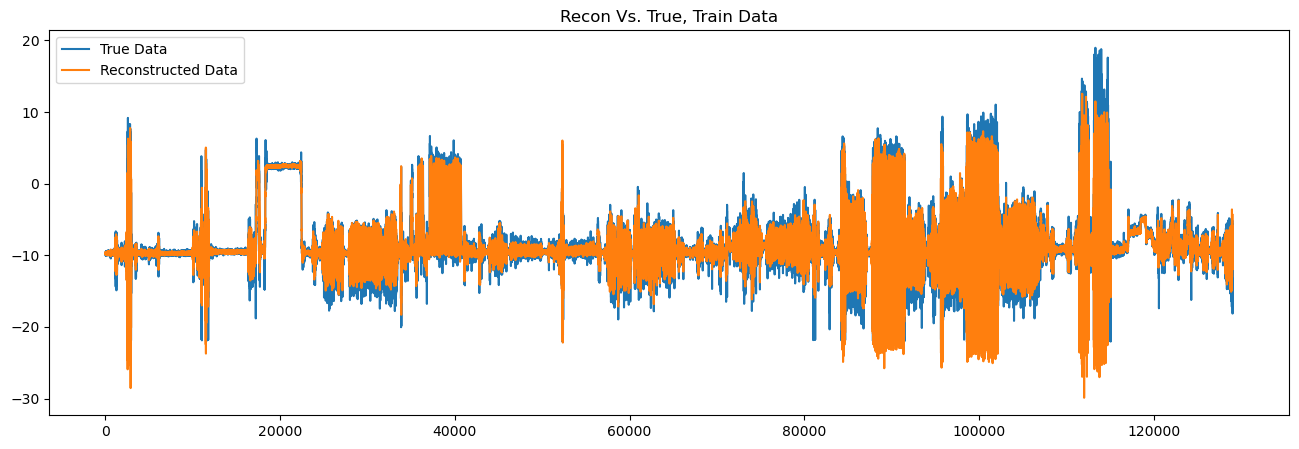

In [64]:
plt.figure(figsize=(16,5))
plt.title("Recon Vs. True, Train Data")
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

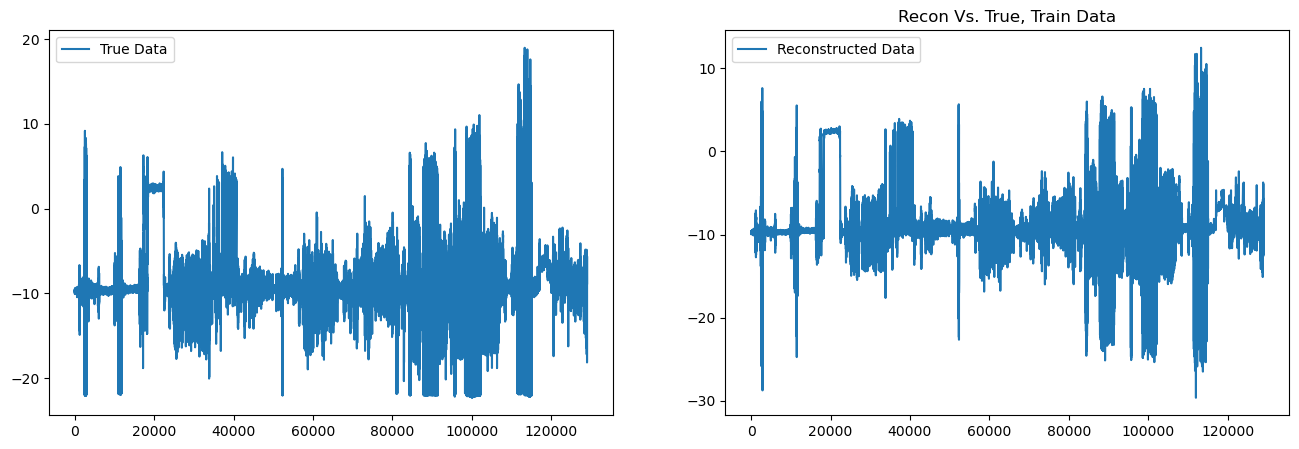

In [49]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(dataset[:split_idx], label="True Data")
plt.legend()
plt.subplot(1,2,2)
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

C:\Users\Admin\AppData\Local\Temp\ipykernel_35176\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


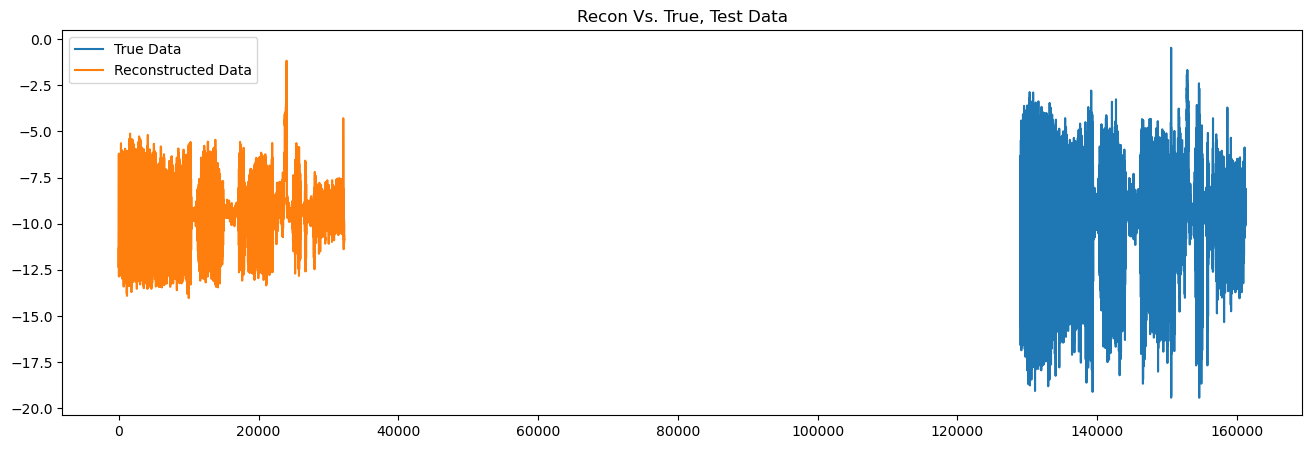

In [ ]:
test_recon = predict(model, test_loader)

plt.figure(figsize=(16,5))
plt.plot(dataset[split_idx:], label="True Data")
plt.plot(test_recon.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Test Data")
plt.legend()

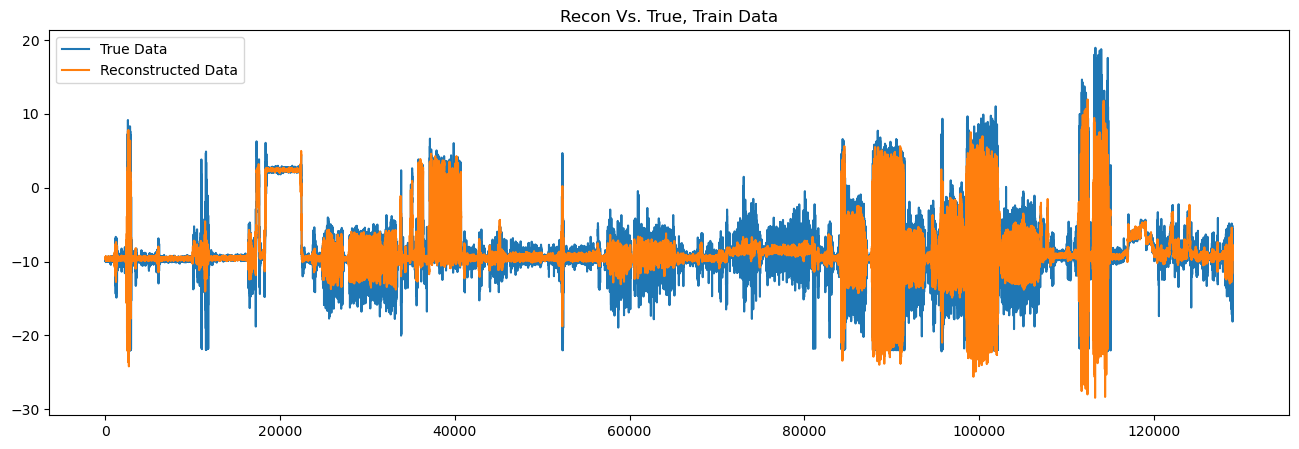

In [ ]:
# plt.subplots(2)
plt.figure(figsize=(16,5))
plt.plot(dataset[:split_idx], label="True Data")
plt.plot(reconstruction.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

In [37]:
subject_2 = pd.read_csv('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject2.csv')
sub_2_split_idx = int(len(subject_2) * 0.8)
subject_2 = subject_2['chest acceleration X-axis']

subject_2

0        -9.8646
1        -9.7753
2        -9.6195
3        -9.7610
4        -9.8078
           ...  
130556   -9.4231
130557   -9.5361
130558   -9.4680
130559   -9.6448
130560   -9.0025
Name: chest acceleration X-axis, Length: 130561, dtype: float64

In [38]:
# training dataset
sub_2_train = mHealth(
    dataframe=subject_2[:split_idx],
)

sub_2_test = mHealth(
    dataframe=subject_2[split_idx:],
)

sub_2_whole = mHealth(
    dataframe=subject_2,
)

sub_2_train_loader = torch.utils.data.DataLoader(
    dataset=sub_2_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_2_test_loader = torch.utils.data.DataLoader(
    dataset=sub_2_test,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_2_whole_loader = torch.utils.data.DataLoader(
    dataset=sub_2_whole,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

In [39]:
sub_2_recon = predict(model, sub_2_whole_loader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25788\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


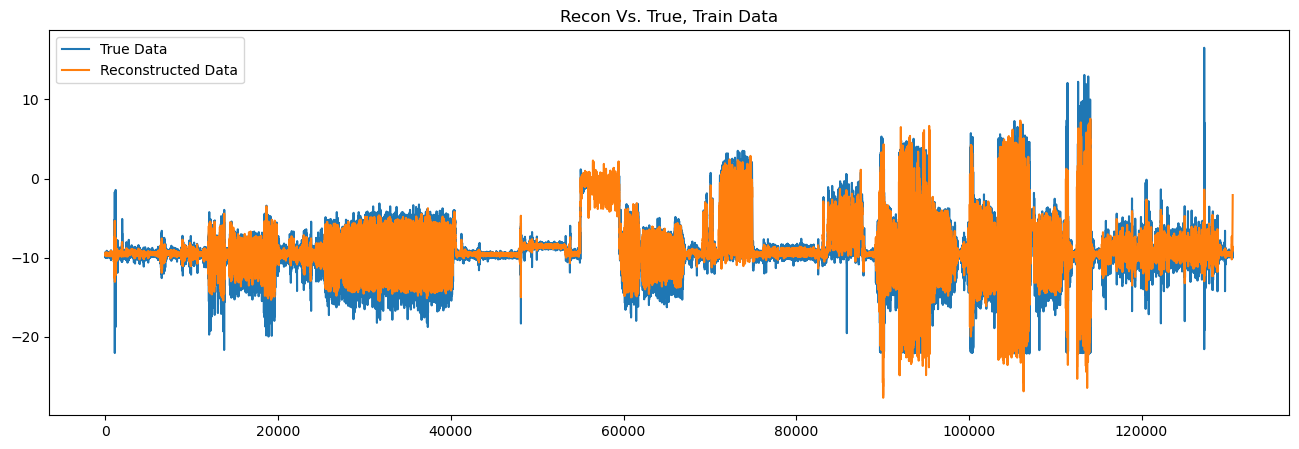

In [40]:
# plt.subplots(2)
plt.figure(figsize=(16,5))
plt.plot(subject_2, label="True Data")
plt.plot(sub_2_recon.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True, Train Data")
plt.legend()

C:\Users\Admin\AppData\Local\Temp\ipykernel_35176\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


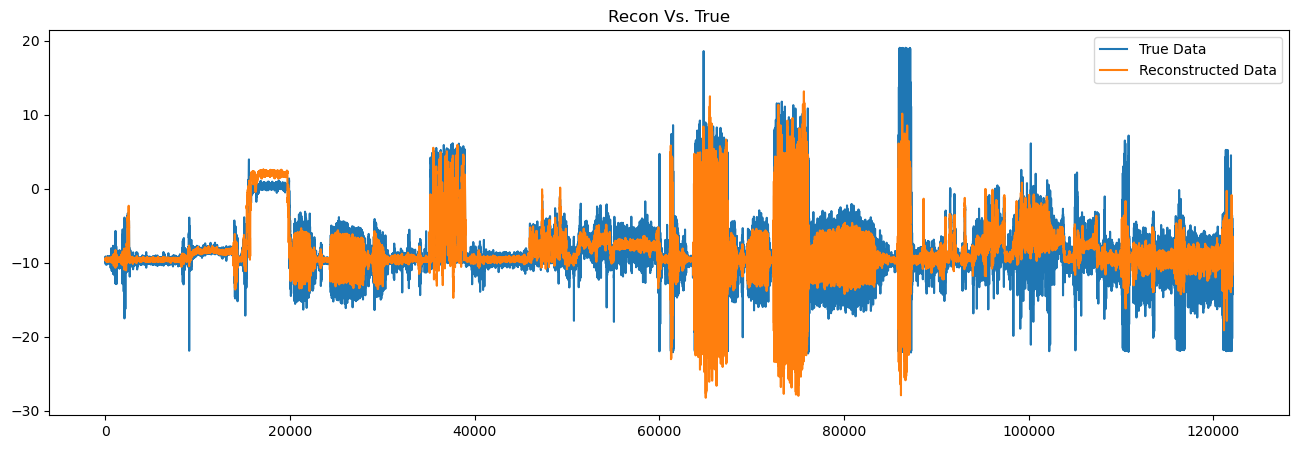

In [ ]:
subject_3 = pd.read_csv('C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject3.csv')
sub_3_split_idx = int(len(subject_3) * 0.8)
subject_3 = subject_3['chest acceleration X-axis']

# training dataset
sub_3_train = mHealth(
    dataframe=subject_3[:split_idx],
)

sub_3_test = mHealth(
    dataframe=subject_3[split_idx:],
)

sub_3_whole = mHealth(
    dataframe=subject_3,
)

sub_3_train_loader = torch.utils.data.DataLoader(
    dataset=sub_3_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_3_test_loader = torch.utils.data.DataLoader(
    dataset=sub_3_test,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_3_whole_loader = torch.utils.data.DataLoader(
    dataset=sub_3_whole,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

sub_3_recon = predict(model, sub_3_whole_loader)

# plt.subplots(2)
plt.figure(figsize=(16,5))
plt.plot(subject_3, label="True Data")
plt.plot(sub_3_recon.cpu(), label="Reconstructed Data")
plt.title("Recon Vs. True")
plt.legend()

In [11]:
def plot_predictions(model):
    for i in range(1):

        path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV\\mHealth_subject' + str(i+1) + '.csv'
        df = pd.read_csv(path)
        
        df = df['chest acceleration X-axis']
        
        dataset = mHealth(
            dataframe=df,
        )
        
        dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=512,
            collate_fn=collate_fn,
            shuffle=False,
            drop_last=True
        )
        
        reconstructed_data = predict(model, dataloader)
        
        plt.figure(figsize=(16,5))
        plt.plot(df, label="True Data")
        plt.plot(reconstructed_data.cpu(), label="Reconstructed Data")
        plt.title("Recon Vs. True, Train Data")
        plt.legend()
                

C:\Users\Admin\AppData\Local\Temp\ipykernel_11488\1931177812.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


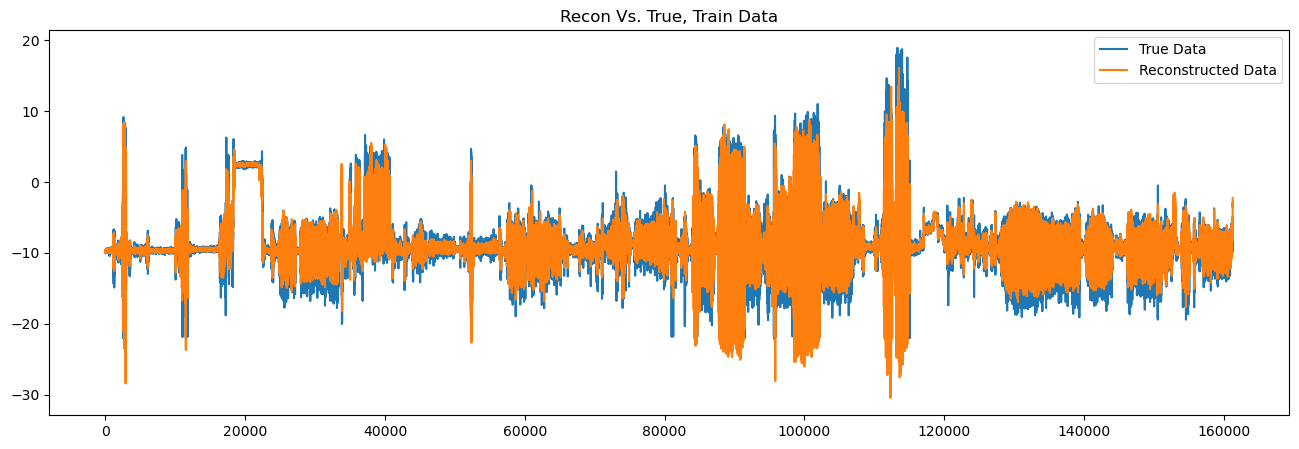

In [12]:
plot_predictions(model)

In [21]:
from sklearn.preprocessing import MinMaxScaler

def plot_predictions_daphnet(model):
    # for i in range(10):

    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\smartphone activity detection\\train.csv'
    # path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MobiAct_Dataset_v2.0\\Annotated Data\\BSC\\BSC_1_1_annotated.csv'
    path = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\UPFallCompleteDataSet.csv'
    
    df = pd.read_csv(path)
    # df = df['tBodyAcc-mean()-X']
    # df = df['acc_x']
    df = df['BeltAccelerometer']
    
    
    df = df.to_numpy().reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-10, 10))

    df = scaler.fit_transform(df)
    df = pd.Series(df.squeeze())
    plt.plot(df)
    
    dataset = mHealth(
        dataframe=df,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=512,
        collate_fn=collate_fn,
        shuffle=False,
        drop_last=True
    )
    
    reconstructed_data = predict(model, dataloader)
    
    plt.figure(figsize=(16,5))
    plt.plot(df, label="True Data")
    plt.plot(reconstructed_data.cpu(), label="Reconstructed Data")
    plt.title("Recon Vs. True, Daphnet")
    plt.legend()

In [22]:
plot_predictions_daphnet(model)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11488\1416964816.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


ValueError: could not convert string to float: 'x-axis (g)'

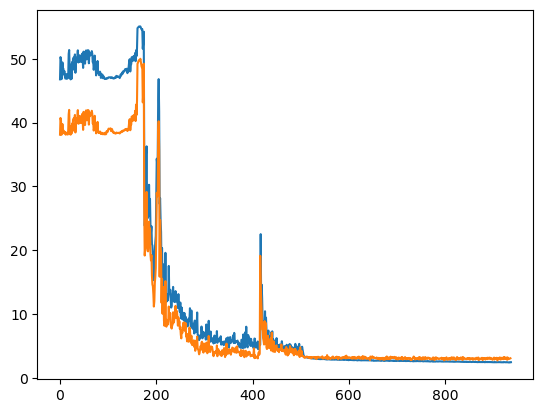

In [45]:
plt.plot(train_loss)
plt.plot(test_loss)

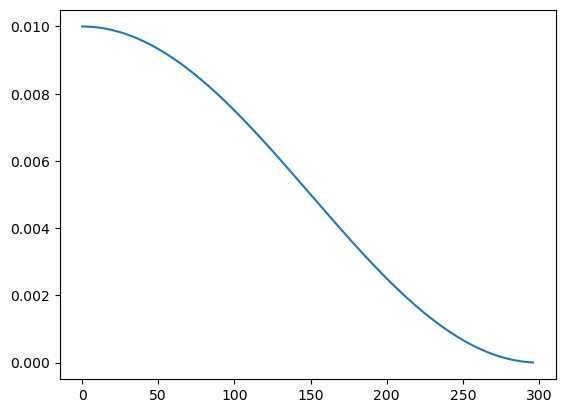

In [ ]:
plt.plot(learning_rate)

In [54]:
# cwd = os.getcwd() + "/MHEALTHDATASET_CSV"
if(platform.system() == 'Windows'):
    cwd = 'C:\\Users\\Admin\\.vscode\\pythonenv\\gait-project\\datasets\\MHEALTHDATASET_CSV'
else:
    cwd = '/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV'

print(cwd)

os.chdir(cwd)

#split data into sections by label

df = pd.DataFrame()
dataframes = []
for file in os.listdir():
    if file.endswith(".csv"):
        file_path = f"{cwd}/{file}"
        temp = pd.read_csv(file_path)
        dataframes.append(temp)
        print('file:', file, '| size = ', len(temp))
        
df = pd.concat(dataframes)

C:\Users\Admin\.vscode\pythonenv\gait-project\datasets\MHEALTHDATASET_CSV
file: mHealth_subject1.csv | size =  161280
file: mHealth_subject10.csv | size =  98304
file: mHealth_subject2.csv | size =  130561
file: mHealth_subject3.csv | size =  122112
file: mHealth_subject4.csv | size =  116736
file: mHealth_subject5.csv | size =  119808
file: mHealth_subject6.csv | size =  98304
file: mHealth_subject7.csv | size =  104448
file: mHealth_subject8.csv | size =  129024
file: mHealth_subject9.csv | size =  135168


In [55]:
#extracts x,y,z chest accel data into different label groups
def partition_data(label, dataframe):
    x_data = []
    y_data = []
    z_data = []
    activity = []
    
    for i in range(len(dataframe)):
        if(df['label'].iloc[i] == label):
            x_data.append(df['chest acceleration X-axis'].iloc[i])
            y_data.append(df['chest acceleration Y-axis'].iloc[i])
            z_data.append(df['chest acceleration Z-axis'].iloc[i])
            activity.append(df['label'].iloc[i])
            
    
    partitioned_df = pd.DataFrame(
                                  {
        'x-axis': x_data,
        'y-axis': y_data,
        'z-axis': z_data,
        'label': activity
                                  })
    
    return partitioned_df

In [56]:
#splitting all mhealth data based on label, used for classification
df_null = partition_data(0, df)
df_stand = partition_data(1, df) 
df_sit = partition_data(2, df)
df_lying = partition_data(3, df)
df_walk = partition_data(4, df)
df_stairs = partition_data(5, df)
df_waist_bend = partition_data(6, df)
df_arms = partition_data(7, df) 
df_knee_bend = partition_data(8, df) 
df_cycle = partition_data(9, df) 
df_jog = partition_data(10, df) 
df_run = partition_data(11, df) 
df_jump = partition_data(12, df) 

In [57]:
class Classifier(nn.Module):

    def __init__(self, input_dim=128, num_classes=13, num_units=8, dropout=0.5, hidden=True):
        super(Classifier, self).__init__()
        self.fcin = nn.Linear(input_dim, num_units)
        self.fchidden = nn.Linear(num_units, num_units)
        self.fcout = nn.Linear(num_units, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.act = torch.nn.ReLU()
        self.h = hidden


    def forward(self, x):
        x = self.act(self.fcin(x))
        if self.h:
          x = self.act(self.fchidden(x))
        x = self.dropout(x)
        x = self.fcout(x)
        return x

In [59]:
encoded = Encoder(df_jump['x-axis'][:128])

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got Series"

In [ ]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    Net,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss()

)